In [49]:
import pandas as pd
import tensorflow as tf
from attrdict import AttrDict
from lazy import lazy
import tarfile
import re
import urllib.request
import os
import random

import pickle
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from collections import Counter

In [50]:
!! unzip data.zip

['Archive:  data.zip',
 'replace data/nice_embed_tsne.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [51]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [52]:
family_classification_metadata = pd.read_table('data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('data/family_classification_sequences.tab')

In [53]:
def get_families_names():
    family_cnt = Counter()
    
    for ind in family_classification_metadata["FamilyID"]:
        family_cnt[ind] += 1

    familys_most_frequent_long = family_cnt.most_common(1000)
    familys_most_frequent = dict()
    for i in range(1000):
        familys_most_frequent[familys_most_frequent_long[i][0]] = i
    return familys_most_frequent

In [54]:
def read_or_new_pickle(path, default):
    try:
        with open(path, "rb") as f:
            return pickle.load(f)
    except Exception:
        result = default()
        with open(path, "wb") as f:
            pickle.dump(result, f)
    return result

In [55]:
families_names = read_or_new_pickle('families_names.pickle', get_families_names)

In [56]:
MAX_PROTEIN_LEN = 400
indices = list()

for i in range(len(family_classification_metadata)):
    if len(family_classification_sequences['Sequences'][i]) < MAX_PROTEIN_LEN and family_classification_metadata["FamilyID"][i] in families_names:
        indices.append(i)
indices = np.array(indices)
np.random.shuffle(indices)
train_ratio = 0.8

train_id = indices[:int(len(indices) * train_ratio)]
test_id = indices[int(len(indices) * train_ratio):]
random.shuffle(train_id)
random.shuffle(test_id)

In [57]:
embed_matrix = pd.read_csv("protVec_100d_3grams.csv", sep='\\t', header=None, engine='python', index_col=0)
trigrams = embed_matrix.index.tolist()
trigrams_to_id = dict()
embeddings = list()
trigrams_to_embeddings = dict()
for i in range(len(trigrams)):
    trigrams_to_id[trigrams[i]]=i
    vec = np.array(embed_matrix.values[i])
    embeddings.append(vec)
    trigrams_to_embeddings[trigrams[i]] = vec

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embed_matrix)
tsne_df = pd.DataFrame(embeddings_tsne, columns=['x0', 'x1'])

In [44]:
tsne_df.head()

,x0,x1
0,39.040707,-16.329958
1,-7.831030,-12.659727
2,-21.953699,-2.599180
3,-7.643764,-12.537953
4,-7.616100,-12.775255


In [ ]:
answer = []
for i in range(len(family_classification_metadata)):
    for class_num in range(2):
        if (family_classification_metadata["FamilyID"][i] == families_names[class_num]):
            seq = family_classification_sequences["Sequences"][i]
            num0, num1 = 0, 0
            for j in range(0,len(seq) - 1, 3):
                subseq = seq[j:j + 3]
                if (len(subseq) == 3):
                    num0 += tsne_df["x0"][trigrams_to_id[subseq]]
                    num1 += tsne_df["x1"][trigrams_to_id[subseq]]
            answer.append([num0, num1, class_num])

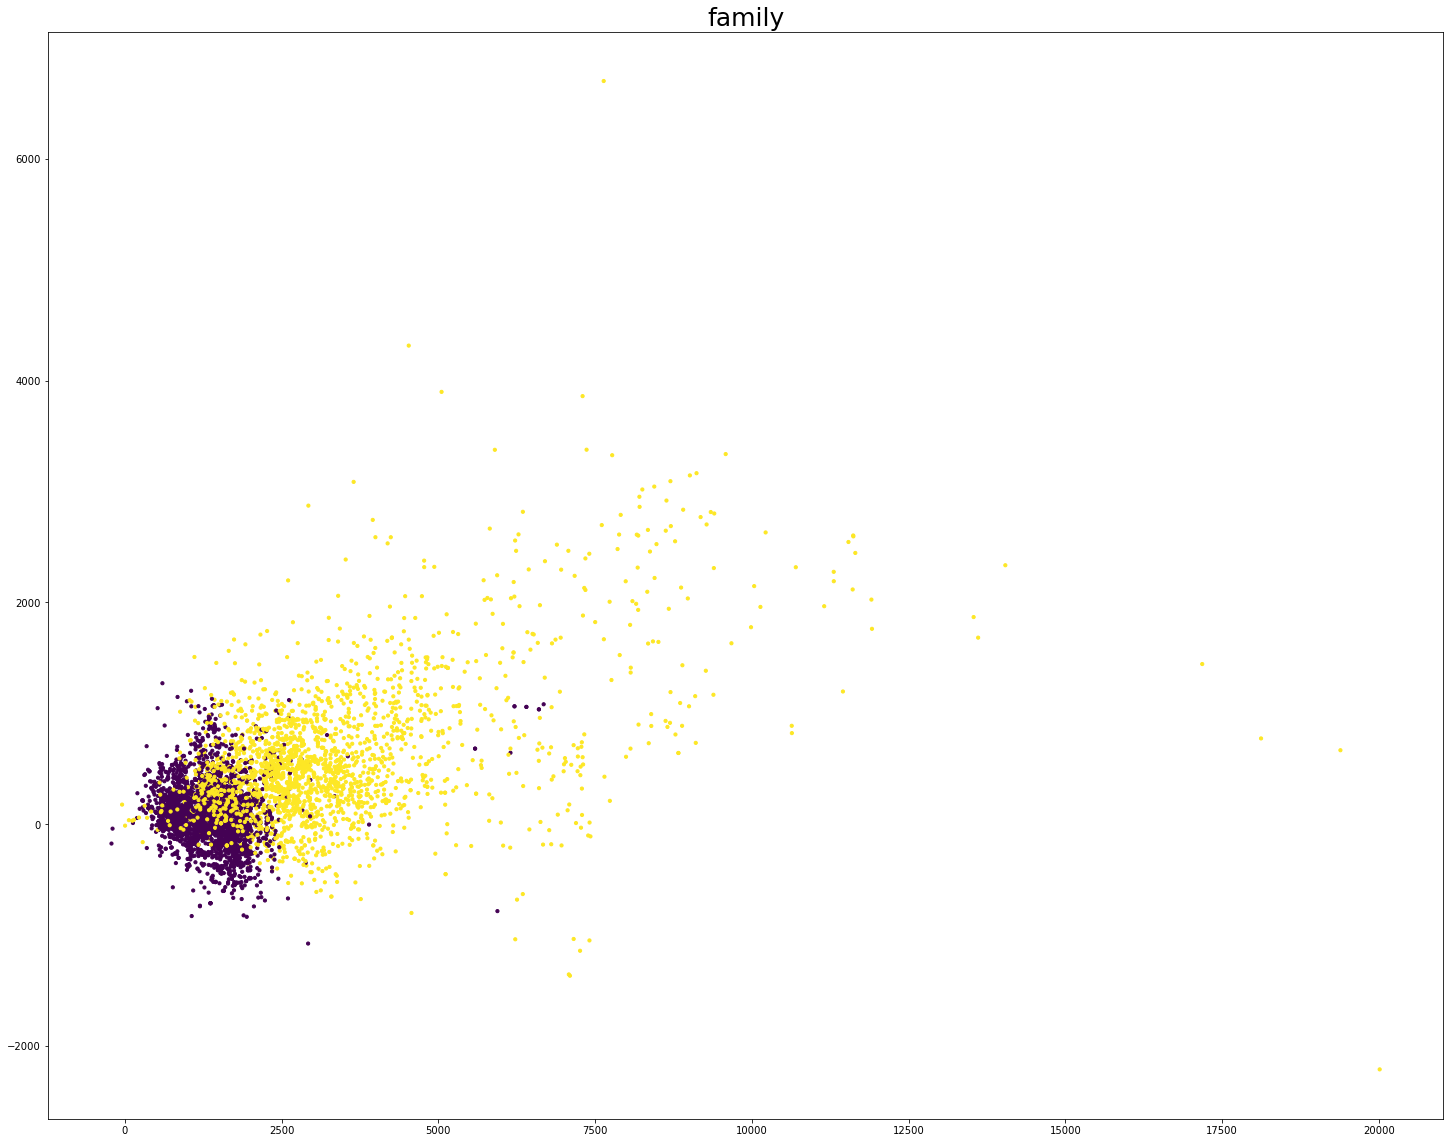

In [65]:
def plot_embedding_properties(answer):
    plt.figure(figsize=(25, 20))
    plt.title("family", fontsize=25)
    plt.scatter(answer[0], answer[1], c=answer[2], s=10)
    plt.show()

plot_embedding_properties(np.array(answer).T)

In [58]:
class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, 1000])
            self.target
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    @lazy
    def length(self):
    # First, we obtain the lengths of sequences in the current data batch. We need this since
    # the data comes as a single tensor, padded with zero vectors to the longest review length.
    # Instead of keeping track of the sequence lengths of every review, we just compute it
    # dynamically in TensorFlow.
    
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
    # Note that the last relevant output activation of the RNN has a different index for each
    # sequence in the training batch. This is because each review has a different length. We
    # already know the length of each sequence.
    # The problem is that we want to index in the dimension of time steps, which is
    # the second dimension in the batch of shape  (sequences, time_steps, word_vectors) .
    
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
    # RNNs are quite hard to train and weights tend to diverge if the hyper parameters do not
    # play nicely together. The idea of gradient clipping is to restrict the the values of the
    # gradient to a sensible range. This way, we can limit the maximum weight updates.

        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            # As of now, TensorFlow only supports indexing along the first dimension, using
            # tf.gather() . We thus flatten the first two dimensions of the output activations from their
            # shape of  sequences x time_steps x word_vectors  and construct an index into this resulting tensor.
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            # The index takes into account the start indices for each sequence in the flat tensor and adds
            # the sequence length to it. Actually, we only add  length - 1  so that we select the last valid
            # time step.
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [59]:
params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=256,
    optimizer=tf.train.AdamOptimizer(0.001),
    batch_size=256,
    gradient_clipping=100,
    seq_length=400,
    embed_length=100
)

In [60]:
def generate_batch(batch_inds):
    proteins = np.array(family_classification_sequences['Sequences'])[batch_inds]
    prots = list()        
    for i in range(proteins.shape[0]):
        protein = proteins[i]
        embeded = list()
        for i in range(0, len(protein) - 3, 3):
            try:
                embeded.append(trigrams_to_embeddings[protein[i: i + 3]])
            except KeyError:
                embeded.append(trigrams_to_embeddings['<unk>'])

        embeded = np.array(embeded)            
        if (embeded.shape[0] < MAX_PROTEIN_LEN / 3):
            embeded = np.vstack((embeded, np.zeros(shape=(MAX_PROTEIN_LEN - embeded.shape[0], 100))))
        prots.append(embeded)

    families = np.array(family_classification_metadata['FamilyID'])[batch_inds]
    fams = list()

    for i in range(families.shape[0]):
        fams.append(families_names[families[i]])
    fams = np.array(fams)
    return np.array(prots), np.eye(1000)[fams]

def generate_train():
    while True:
        batch_inds = np.random.choice(train_id, 256)
        data, target = generate_batch(batch_inds)
        yield data, target
        

        
def generate_test():  
    for i in range(0, test_id.shape[0], 256):
        batch_inds = test_id[i: i + 256]
        data, target = generate_batch(batch_inds)
        yield data, target

In [61]:
tf.reset_default_graph()
model = SequenceClassificationModel(params)
save_dir = 'checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'protein')

/home/malysheva/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
#Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/protein
Failed to restore checkpoint. Initializing variables instead.
1: 100.0%
Saved checkpoint.
2: 98.8%
3: 99.2%
4: 96.5%
5: 99.6%
6: 98.8%
7: 98.4%
8: 99.6%
9: 99.2%
10: 99.2%
11: 99.2%
Saved checkpoint.
12: 98.4%
13: 100.0%
14: 99.6%
15: 98.0%
16: 98.0%
17: 100.0%
18: 99.2%
19: 99.6%
20: 98.8%
21: 98.0%
Saved checkpoint.
22: 100.0%
23: 98.4%
24: 98.8%
25: 100.0%
26: 98.8%
27: 99.2%
28: 99.6%
29: 98.8%
30: 99.2%
31: 99.6%
Saved checkpoint.
32: 99.6%
33: 98.8%
34: 99.2%
35: 99.2%
36: 96.1%
37: 98.8%
38: 99.2%
39: 99.2%
40: 99.6%
41: 99.2%
Saved checkpoint.
42: 98.8%
43: 99.6%
44: 100.0%
45: 99.2%
46: 99.6%
47: 99.2%
48: 97.3%
49: 98.4%
50: 99.2%
51: 99.2%
Saved checkpoint.
52: 99.6%
53: 98.8%
54: 99.6%
55: 99.2%
56: 98.4%
57: 99.6%
58: 99.2%
59: 98.4%
60: 99.2%
61: 100.0%
Saved checkpoint.
62: 99.6%
63: 99.2%
64: 99.6%
65: 98.8%
66: 99.6%
67: 99.6%
68: 99.6%
69: 99.2%
70: 99.2%
71: 99.6%
Saved checkpoint.
72: 98.8%
73: 98.8%
74: 99.2%
75: 99.2%
76: 99.2%
77: 98.0%
78: 97.3%
79: 99.6%
80: 99.2%
81: 97.7%
Saved checkpoint.
82: 98.8%
83: 98.0%
84: 98.8%
85: 98.4%
86: 99.6%
87: 95.3%
88: 98.0%
89: 99.2%
90: 98.8%
91: 97.3%
Saved checkpoint.
92: 98.8%
93: 98.8%
94: 97.3%
95: 98.4%
96: 98.4%
97: 99.2%
98: 99.2%
99: 99.2%
100: 98.4%
101: 98.4%
Saved checkpoint.
102: 97.3%
103: 98.8%
104: 98.8%
105: 97.3%
106: 99.2%
107: 98.0%
108: 97.3%
109: 97.3%
110: 98.0%
111: 97.7%
Saved checkpoint.
112: 98.4%
113: 96.5%
114: 94.1%
115: 96.9%
116: 97.7%
117: 97.3%
118: 98.0%
119: 97.7%
120: 96.9%
121: 97.3%
Saved checkpoint.
122: 97.3%
123: 94.9%
124: 94.9%
125: 96.1%
126: 97.3%
127: 94.9%
128: 98.0%
129: 98.0%
130: 97.3%
131: 96.1%
Saved checkpoint.
132: 96.5%
133: 98.0%
134: 94.9%
135: 97.7%
136: 96.9%
137: 94.5%
138: 95.7%
139: 97.3%
140: 96.5%
141: 95.7%
Saved checkpoint.
142: 95.7%
143: 96.5%
144: 95.3%
145: 98.0%
146: 95.3%
147: 96.1%
148: 96.1%
149: 99.2%
150: 95.7%
151: 97.7%
Saved checkpoint.
152: 92.2%
153: 94.1%
154: 96.5%
155: 97.3%
156: 94.9%
157: 96.1%
158: 94.9%
159: 96.9%
160: 97.7%
161: 95.3%
Saved checkpoint.
162: 94.1%
163: 95.7%
164: 97.3%
165: 96.1%
166: 94.9%
167: 98.0%
168: 96.1%
169: 94.5%
170: 94.9%
171: 95.3%
Saved checkpoint.
172: 94.1%
173: 95.3%
174: 94.5%
175: 96.1%
176: 97.3%
177: 93.8%
178: 96.9%
179: 95.7%
180: 95.7%
181: 94.9%
Saved checkpoint.
182: 92.2%
183: 94.9%
184: 93.8%
185: 95.7%
186: 94.5%
187: 95.7%
188: 95.7%
189: 96.1%
190: 95.3%
191: 96.5%
Saved checkpoint.
192: 96.5%
193: 95.3%
194: 93.8%
195: 93.8%
196: 96.1%
197: 95.7%
198: 96.9%
199: 96.1%
200: 92.2%
201: 91.8%
Saved checkpoint.
202: 92.6%
203: 93.8%
204: 93.4%
205: 91.8%
206: 94.1%
207: 90.6%
208: 94.1%
209: 93.0%
210: 93.0%
211: 94.5%
Saved checkpoint.
212: 94.1%
213: 96.5%
214: 90.6%
215: 92.2%
216: 94.5%
217: 95.3%
218: 92.2%
219: 95.7%
220: 97.3%
221: 92.2%
Saved checkpoint.
222: 93.0%
223: 93.4%
224: 93.0%
225: 93.4%
226: 89.5%
227: 91.8%
228: 94.1%
229: 96.5%
230: 92.2%
231: 91.4%
Saved checkpoint.
232: 93.4%
233: 94.1%
234: 93.8%
235: 95.3%
236: 95.7%
237: 93.8%
238: 93.8%
239: 93.0%
240: 92.2%
241: 94.5%
Saved checkpoint.
242: 93.0%
243: 93.8%
244: 90.2%
245: 88.3%
246: 91.8%
247: 90.6%
248: 89.5%
249: 91.8%
250: 93.4%
251: 93.0%
Saved checkpoint.
252: 94.1%
253: 91.4%
254: 94.5%
255: 94.1%
256: 93.4%
257: 91.4%
258: 93.0%
259: 91.4%
260: 93.4%
261: 89.5%
Saved checkpoint.
262: 90.6%
263: 92.6%
264: 87.9%
265: 90.6%
266: 90.2%
267: 92.2%
268: 91.0%
269: 92.6%
270: 89.5%
271: 89.8%
Saved checkpoint.
272: 92.6%
273: 93.0%
274: 89.8%
275: 89.8%
276: 89.5%
277: 86.3%
278: 88.3%
279: 89.8%
280: 90.6%
281: 91.8%
Saved checkpoint.
282: 90.6%
283: 89.5%
284: 87.5%
285: 87.9%
286: 93.0%
287: 88.3%
288: 92.2%
289: 92.6%
290: 90.6%
291: 88.7%
Saved checkpoint.
292: 89.1%
293: 88.7%
294: 91.0%
295: 91.8%
296: 89.8%
297: 90.6%
298: 91.8%
299: 92.6%
300: 83.6%
301: 87.1%
Saved checkpoint.
302: 91.0%
303: 91.4%
304: 90.2%
305: 91.4%
306: 89.5%
307: 89.8%
308: 90.6%
309: 85.5%
310: 89.1%
311: 86.3%
Saved checkpoint.
312: 88.3%
313: 87.1%
314: 86.3%
315: 91.4%
316: 86.7%
317: 84.0%
318: 89.1%
319: 87.9%
320: 86.7%
321: 87.5%
Saved checkpoint.
322: 85.2%
323: 81.2%
324: 88.7%
325: 86.3%
326: 89.8%
327: 88.7%
328: 83.6%
329: 87.5%
330: 88.7%
331: 89.1%
Saved checkpoint.
332: 87.5%
333: 87.9%
334: 87.1%
335: 84.0%
336: 87.9%
337: 86.7%
338: 86.7%
339: 89.1%
340: 87.9%
341: 84.4%
Saved checkpoint.
342: 89.1%
343: 86.3%
344: 85.5%
345: 85.2%
346: 85.2%
347: 85.5%
348: 87.5%
349: 88.7%
350: 87.9%
351: 85.2%
Saved checkpoint.
352: 83.2%
353: 85.5%
354: 85.2%
355: 84.4%
356: 87.9%
357: 86.3%
358: 89.1%
359: 87.9%
360: 80.5%
361: 85.2%
Saved checkpoint.
362: 86.3%
363: 85.5%
364: 84.8%
365: 84.8%
366: 85.2%
367: 86.3%
368: 83.6%
369: 85.5%
370: 79.7%
371: 86.7%
Saved checkpoint.
372: 87.1%
373: 86.7%
374: 84.4%
375: 89.8%
376: 82.8%
377: 77.7%
378: 87.1%
379: 82.4%
380: 83.2%
381: 84.0%
Saved checkpoint.
382: 80.9%
383: 87.9%
384: 83.6%
385: 86.3%
386: 83.6%
387: 81.2%
388: 83.2%
389: 81.6%
390: 84.0%
391: 88.3%
Saved checkpoint.
392: 85.9%
393: 85.9%
394: 84.8%
395: 82.0%
396: 83.6%
397: 89.5%
398: 83.2%
399: 84.0%
400: 84.0%
401: 82.8%
Saved checkpoint.
402: 84.4%
403: 87.9%
404: 86.7%
405: 84.4%
406: 84.4%
407: 85.5%
408: 80.1%
409: 83.6%
410: 80.9%
411: 87.1%
Saved checkpoint.
412: 80.9%
413: 81.2%
414: 87.1%
415: 85.2%
416: 82.4%
417: 81.6%
418: 85.9%
419: 87.1%
420: 81.2%
421: 80.9%
Saved checkpoint.
422: 79.7%
423: 78.5%
424: 80.9%
425: 83.6%
426: 82.4%
427: 84.4%
428: 85.9%
429: 84.0%
430: 80.1%
431: 80.5%
Saved checkpoint.
432: 85.9%
433: 82.4%
434: 82.4%
435: 79.3%
436: 84.0%
437: 79.7%
438: 82.0%
439: 79.7%
440: 86.7%
441: 83.6%
Saved checkpoint.
442: 82.8%
443: 86.7%
444: 84.4%
445: 85.9%
446: 79.7%
447: 80.1%
448: 84.0%
449: 85.5%
450: 81.6%
451: 84.8%
Saved checkpoint.
452: 78.5%
453: 85.2%
454: 79.3%
455: 82.8%
456: 88.7%
457: 82.4%
458: 82.8%
459: 82.8%
460: 86.7%
461: 84.4%
Saved checkpoint.
462: 82.8%
463: 81.2%
464: 81.6%
465: 82.0%
466: 84.0%
467: 83.2%
468: 79.3%
469: 84.0%
470: 83.2%
471: 84.4%
Saved checkpoint.
472: 80.5%
473: 77.7%
474: 78.9%
475: 80.5%
476: 82.0%
477: 79.3%
478: 83.2%
479: 82.0%
480: 80.5%
481: 84.0%
Saved checkpoint.
482: 82.4%
483: 82.0%
484: 83.6%
485: 82.4%
486: 83.6%
487: 80.9%
488: 79.7%
489: 80.9%
490: 82.8%
491: 79.7%
Saved checkpoint.
492: 78.5%
493: 80.1%
494: 85.5%
495: 80.5%
496: 87.9%
497: 78.9%
498: 85.5%
499: 82.0%
500: 89.1%
501: 82.0%
Saved checkpoint.
502: 84.8%
503: 85.2%
504: 88.7%
505: 77.0%
506: 86.3%
507: 79.3%
508: 87.5%
509: 81.2%
510: 78.1%
511: 84.0%
Saved checkpoint.
512: 85.2%
513: 79.3%
514: 82.8%
515: 81.2%
516: 79.7%
517: 82.0%
518: 80.9%
519: 78.1%
520: 83.2%
521: 85.2%
Saved checkpoint.
522: 80.1%
523: 82.4%
524: 84.4%
525: 81.6%
526: 84.0%
527: 81.6%
528: 84.0%
529: 81.6%
530: 80.5%
531: 85.9%
Saved checkpoint.
532: 77.3%
533: 80.5%
534: 80.9%
535: 77.7%
536: 78.5%
537: 77.3%
538: 78.9%
539: 80.9%
540: 81.6%
541: 78.1%
Saved checkpoint.
542: 78.5%
543: 81.2%
544: 80.9%
545: 79.3%
546: 75.4%
547: 80.1%
548: 79.7%
549: 78.5%
550: 76.6%
551: 80.9%
Saved checkpoint.
552: 73.4%
553: 75.4%
554: 82.8%
555: 81.2%
556: 77.7%
557: 78.1%
558: 78.1%
559: 83.6%
560: 80.9%
561: 81.6%
Saved checkpoint.
562: 77.7%
563: 83.6%
564: 77.3%
565: 81.2%
566: 75.8%
567: 76.2%
568: 83.2%
569: 85.9%
570: 77.3%
571: 80.5%
Saved checkpoint.
572: 80.9%
573: 80.1%
574: 78.9%
575: 82.0%
576: 80.9%
577: 80.5%
578: 82.0%
579: 77.0%
580: 77.7%
581: 79.3%
Saved checkpoint.
582: 78.1%
583: 79.3%
584: 79.7%
585: 80.5%
586: 80.9%
587: 78.5%
588: 76.6%
589: 78.9%
590: 75.0%
591: 77.7%
Saved checkpoint.
592: 84.4%
593: 81.2%
594: 79.7%
595: 78.5%
596: 77.3%
597: 77.0%
598: 79.7%
599: 80.1%
600: 76.2%
601: 78.5%
Saved checkpoint.
602: 76.6%
603: 78.1%
604: 77.3%
605: 79.7%
606: 77.3%
607: 75.4%
608: 75.8%
609: 77.3%
610: 75.4%
611: 81.2%
Saved checkpoint.
612: 79.7%
613: 76.2%
614: 80.1%
615: 77.0%
616: 79.3%
617: 74.6%
618: 77.0%
619: 73.8%
620: 71.9%
621: 81.6%
Saved checkpoint.
622: 80.9%
623: 80.5%
624: 77.3%
625: 77.0%
626: 78.9%
627: 75.4%
628: 78.5%
629: 77.3%
630: 77.0%
631: 80.9%
Saved checkpoint.
632: 73.8%
633: 76.2%
634: 76.2%
635: 80.1%
636: 77.7%
637: 76.6%
638: 78.9%
639: 78.9%
640: 75.0%
641: 80.1%
Saved checkpoint.
642: 78.9%
643: 73.4%
644: 80.1%
645: 77.3%
646: 73.8%
647: 77.0%
648: 77.0%
649: 76.2%
650: 77.0%
651: 76.6%
Saved checkpoint.
652: 78.1%
653: 77.7%
654: 77.0%
655: 77.0%
656: 77.0%
657: 73.4%
658: 80.9%
659: 71.5%
660: 79.3%
661: 72.7%
Saved checkpoint.
662: 76.6%
663: 77.3%
664: 76.2%
665: 75.8%
666: 74.6%
667: 75.0%
668: 75.4%
669: 82.0%
670: 72.7%
671: 75.8%
Saved checkpoint.
672: 76.6%
673: 77.3%
674: 75.8%
675: 73.0%
676: 78.5%
677: 75.0%
678: 76.2%
679: 79.3%
680: 81.2%
681: 73.8%
Saved checkpoint.
682: 80.1%
683: 73.8%
684: 79.3%
685: 72.7%
686: 78.1%
687: 74.6%
688: 74.2%
689: 78.1%
690: 80.9%
691: 74.2%
Saved checkpoint.
692: 77.3%
693: 74.2%
694: 79.3%
695: 79.3%
696: 74.2%
697: 74.2%
698: 77.7%
699: 75.8%
700: 71.1%
701: 72.3%
Saved checkpoint.
702: 76.2%
703: 75.0%
704: 77.0%
705: 78.9%
706: 74.2%
707: 72.3%
708: 80.1%
709: 77.3%
710: 71.1%
711: 76.2%
Saved checkpoint.
712: 72.7%
713: 73.0%
714: 81.6%
715: 74.6%
716: 78.9%
717: 77.3%
718: 76.2%
719: 73.0%
720: 78.1%
721: 75.0%
Saved checkpoint.
722: 76.2%
723: 73.8%
724: 73.0%
725: 76.6%
726: 73.4%
727: 70.3%
728: 73.8%
729: 75.8%
730: 70.3%
731: 71.9%
Saved checkpoint.
732: 77.7%
733: 76.2%
734: 69.9%
735: 71.1%
736: 69.9%
737: 72.3%
738: 68.8%
739: 77.3%
740: 77.3%
741: 75.8%
Saved checkpoint.
742: 78.9%
743: 70.3%
744: 74.6%
745: 70.7%
746: 72.7%
747: 72.7%
748: 68.0%
749: 76.2%
750: 77.0%
751: 81.2%
Saved checkpoint.
752: 74.6%
753: 73.8%
754: 77.7%
755: 74.6%
756: 79.3%
757: 75.8%
758: 73.4%
759: 76.6%
760: 76.6%
761: 76.2%
Saved checkpoint.
762: 74.2%
763: 74.2%
764: 78.1%
765: 71.5%
766: 69.9%
767: 71.9%
768: 79.3%
769: 72.7%
770: 75.4%
771: 76.2%
Saved checkpoint.
772: 69.5%
773: 72.3%
774: 75.4%
775: 77.0%
776: 73.4%
777: 70.3%
778: 72.3%
779: 74.2%
780: 73.4%
781: 77.0%
Saved checkpoint.
782: 79.3%
783: 71.5%
784: 71.9%
785: 78.1%
786: 77.0%
787: 69.5%
788: 77.7%
789: 77.0%
790: 71.9%
791: 71.5%
Saved checkpoint.
792: 75.0%
793: 75.8%
794: 78.5%
795: 71.5%
796: 75.8%
797: 76.6%
798: 77.3%
799: 75.8%
800: 79.7%
801: 69.9%
Saved checkpoint.
802: 76.6%
803: 75.0%
804: 71.1%
805: 74.6%
806: 73.0%
807: 73.4%
808: 75.4%
809: 75.4%
810: 71.9%
811: 73.8%
Saved checkpoint.
812: 75.8%
813: 71.5%
814: 72.7%
815: 69.9%
816: 74.6%
817: 73.0%
818: 77.7%
819: 76.6%
820: 69.9%
821: 73.0%
Saved checkpoint.
822: 71.9%
823: 66.4%
824: 71.9%
825: 74.6%
826: 73.8%
827: 71.1%
828: 67.2%
829: 71.9%
830: 75.0%
831: 66.0%
Saved checkpoint.
832: 70.3%
833: 75.8%
834: 78.5%
835: 70.3%
836: 70.3%
837: 71.1%
838: 69.9%
839: 70.3%
840: 72.3%
841: 78.5%
Saved checkpoint.
842: 72.7%
843: 67.2%
844: 73.8%
845: 68.0%
846: 71.9%
847: 73.0%
848: 71.1%
849: 75.0%
850: 73.0%
851: 71.9%
Saved checkpoint.
852: 76.6%
853: 71.9%
854: 75.4%
855: 67.6%
856: 73.8%
857: 69.1%
858: 69.1%
859: 68.8%
860: 78.9%
861: 72.7%
Saved checkpoint.
862: 68.8%
863: 76.2%
864: 77.7%
865: 71.9%
866: 68.4%
867: 73.4%
868: 74.6%
869: 72.7%
870: 74.6%
871: 71.1%
Saved checkpoint.
872: 73.0%
873: 74.6%
874: 73.0%
875: 65.6%
876: 70.7%
877: 70.7%
878: 70.7%
879: 69.9%
880: 64.8%
881: 68.8%
Saved checkpoint.
882: 74.2%
883: 66.0%
884: 67.6%
885: 71.9%
886: 69.5%
887: 65.6%
888: 71.9%
889: 72.7%
890: 69.9%
891: 70.7%
Saved checkpoint.
892: 73.4%
893: 74.2%
894: 69.5%
895: 68.0%
896: 71.9%
897: 70.7%
898: 72.7%
899: 74.6%
900: 65.2%
901: 69.9%
Saved checkpoint.
902: 66.8%
903: 68.4%
904: 73.8%
905: 75.8%
906: 71.9%
907: 73.0%
908: 76.6%
909: 71.5%
910: 68.4%
911: 70.7%
Saved checkpoint.
912: 69.5%
913: 67.6%
914: 68.8%
915: 72.3%
916: 68.4%
917: 74.2%
918: 69.9%
919: 68.0%
920: 71.5%
921: 76.2%
Saved checkpoint.
922: 72.7%
923: 69.9%
924: 67.6%
925: 68.8%
926: 73.0%
927: 77.3%
928: 68.8%
929: 74.2%
930: 69.5%
931: 72.7%
Saved checkpoint.
932: 69.9%
933: 71.5%
934: 69.5%
935: 71.1%
936: 71.9%
937: 70.3%
938: 70.3%
939: 72.7%
940: 63.3%
941: 69.9%
Saved checkpoint.
942: 76.6%
943: 73.4%
944: 60.2%
945: 69.1%
946: 71.9%
947: 63.7%
948: 66.4%
949: 68.4%
950: 70.3%
951: 69.1%
Saved checkpoint.
952: 71.1%
953: 69.9%
954: 74.6%
955: 72.7%
956: 69.5%
957: 65.2%
958: 66.4%
959: 71.9%
960: 66.8%
961: 69.1%
Saved checkpoint.
962: 67.6%
963: 67.2%
964: 67.2%
965: 72.7%
966: 69.9%
967: 64.5%
968: 72.7%
969: 65.6%
970: 63.3%
971: 69.1%
Saved checkpoint.
972: 72.7%
973: 68.8%
974: 69.9%
975: 71.9%
976: 66.8%
977: 71.1%
978: 64.5%
979: 62.1%
980: 65.6%
981: 63.3%
Saved checkpoint.
982: 69.1%
983: 70.7%
984: 66.8%
985: 71.9%
986: 66.8%
987: 68.8%
988: 68.8%
989: 71.1%
990: 70.3%
991: 67.2%
Saved checkpoint.
992: 72.3%
993: 66.0%
994: 67.2%
995: 70.7%
996: 63.3%
997: 73.0%
998: 69.1%
999: 69.5%
1000: 71.1%
1001: 68.8%
Saved checkpoint.
1002: 69.1%
1003: 66.0%
1004: 68.0%
1005: 63.3%
1006: 73.0%
1007: 71.1%
1008: 72.7%
1009: 66.8%
1010: 60.5%
1011: 67.2%
Saved checkpoint.
1012: 68.0%
1013: 69.1%
1014: 73.4%
1015: 71.9%
1016: 71.1%
1017: 71.9%
1018: 67.2%
1019: 77.0%
1020: 66.4%
1021: 68.8%
Saved checkpoint.
1022: 74.2%
1023: 66.4%
1024: 71.5%
1025: 65.6%
1026: 63.3%
1027: 64.8%
1028: 62.9%
1029: 69.9%
1030: 68.4%
1031: 66.8%
Saved checkpoint.
1032: 65.2%
1033: 60.9%
1034: 66.4%
1035: 71.9%
1036: 65.2%
1037: 68.4%
1038: 67.2%
1039: 70.3%
1040: 69.5%
1041: 69.9%
Saved checkpoint.
1042: 77.0%
1043: 69.9%
1044: 66.4%
1045: 64.1%
1046: 66.0%
1047: 64.5%
1048: 64.8%
1049: 63.3%
1050: 66.8%
1051: 66.4%
Saved checkpoint.
1052: 67.6%
1053: 61.3%
1054: 68.8%
1055: 66.8%
1056: 69.5%
1057: 70.7%
1058: 67.2%
1059: 65.6%
1060: 69.5%
1061: 62.5%
Saved checkpoint.
1062: 67.6%
1063: 64.8%
1064: 63.3%
1065: 63.3%
1066: 68.0%
1067: 67.6%
1068: 63.3%
1069: 67.6%
1070: 62.9%
1071: 64.8%
Saved checkpoint.
1072: 63.3%
1073: 68.8%
1074: 68.4%
1075: 62.9%
1076: 60.5%
1077: 63.3%
1078: 66.8%
1079: 70.7%
1080: 63.3%
1081: 75.0%
Saved checkpoint.
1082: 64.1%
1083: 64.5%
1084: 68.4%
1085: 59.0%
1086: 68.4%
1087: 71.9%
1088: 61.7%
1089: 68.0%
1090: 67.6%
1091: 71.5%
Saved checkpoint.
1092: 65.6%
1093: 69.1%
1094: 62.9%
1095: 62.1%
1096: 64.1%
1097: 67.2%
1098: 68.8%
1099: 68.4%
1100: 67.6%
1101: 64.1%
Saved checkpoint.
1102: 63.7%
1103: 62.5%
1104: 64.1%
1105: 70.7%
1106: 64.1%
1107: 68.0%
1108: 66.0%
1109: 68.4%
1110: 64.5%
1111: 68.0%
Saved checkpoint.
1112: 66.8%
1113: 64.1%
1114: 74.2%
1115: 64.1%
1116: 68.0%
1117: 65.6%
1118: 68.0%
1119: 60.2%
1120: 66.0%
1121: 67.2%
Saved checkpoint.
1122: 69.9%
1123: 62.9%
1124: 62.9%
1125: 64.5%
1126: 64.8%
1127: 64.8%
1128: 72.7%
1129: 65.6%
1130: 66.4%
1131: 66.8%
Saved checkpoint.
1132: 61.3%
1133: 61.7%
1134: 64.1%
1135: 60.9%
1136: 66.4%
1137: 66.4%
1138: 64.5%
1139: 65.2%
1140: 63.3%
1141: 65.6%
Saved checkpoint.
1142: 64.5%
1143: 66.4%
1144: 64.5%
1145: 61.7%
1146: 61.7%
1147: 66.4%
1148: 63.7%
1149: 62.9%
1150: 62.1%
1151: 63.3%
Saved checkpoint.
1152: 64.5%
1153: 63.3%
1154: 70.7%
1155: 62.1%
1156: 62.5%
1157: 66.0%
1158: 68.0%
1159: 60.5%
1160: 61.3%
1161: 69.5%
Saved checkpoint.
1162: 62.5%
1163: 60.2%
1164: 64.5%
1165: 68.0%
1166: 65.2%
1167: 62.5%
1168: 67.6%
1169: 62.1%
1170: 66.8%
1171: 62.5%
Saved checkpoint.
1172: 56.6%
1173: 63.7%
1174: 66.8%
1175: 64.5%
1176: 66.4%
1177: 59.8%
1178: 56.2%
1179: 57.8%
1180: 67.6%
1181: 60.5%
Saved checkpoint.
1182: 63.7%
1183: 64.5%
1184: 65.6%
1185: 60.2%
1186: 56.2%
1187: 61.3%
1188: 54.7%
1189: 65.6%
1190: 66.0%
1191: 62.1%
Saved checkpoint.
1192: 61.3%
1193: 64.5%
1194: 61.7%
1195: 64.1%
1196: 60.2%
1197: 66.0%
1198: 66.0%
1199: 63.7%
1200: 60.2%
1201: 62.1%
Saved checkpoint.
1202: 62.9%
1203: 62.9%
1204: 67.6%
1205: 63.7%
1206: 63.7%
1207: 59.0%
1208: 62.1%
1209: 66.0%
1210: 63.7%
1211: 63.3%
Saved checkpoint.
1212: 66.0%
1213: 68.0%
1214: 67.2%
1215: 60.2%
1216: 58.2%
1217: 64.8%
1218: 68.0%
1219: 61.7%
1220: 68.4%
1221: 64.5%
Saved checkpoint.
1222: 66.0%
1223: 62.5%
1224: 59.8%
1225: 58.6%
1226: 62.5%
1227: 65.2%
1228: 62.1%
1229: 59.8%
1230: 62.5%
1231: 66.4%
Saved checkpoint.
1232: 60.5%
1233: 62.1%
1234: 54.7%
1235: 59.4%
1236: 56.6%
1237: 60.5%
1238: 58.6%
1239: 57.4%
1240: 63.7%
1241: 64.1%
Saved checkpoint.
1242: 57.4%
1243: 60.5%
1244: 62.5%
1245: 61.3%
1246: 57.8%
1247: 62.1%
1248: 65.6%
1249: 58.6%
1250: 56.2%
1251: 58.2%
Saved checkpoint.
1252: 57.0%
1253: 62.9%
1254: 60.5%
1255: 60.9%
1256: 60.9%
1257: 62.5%
1258: 66.4%
1259: 56.2%
1260: 55.5%
1261: 58.2%
Saved checkpoint.
1262: 65.6%
1263: 60.5%
1264: 62.9%
1265: 59.4%
1266: 60.9%
1267: 63.3%
1268: 63.3%
1269: 53.1%
1270: 61.3%
1271: 61.3%
Saved checkpoint.
1272: 64.5%
1273: 59.8%
1274: 60.5%
1275: 59.4%
1276: 64.1%
1277: 60.5%
1278: 62.1%
1279: 65.2%
1280: 57.4%
1281: 60.5%
Saved checkpoint.
1282: 60.9%
1283: 63.3%
1284: 61.7%
1285: 65.6%
1286: 59.8%
1287: 65.2%
1288: 58.2%
1289: 59.8%
1290: 62.9%
1291: 57.8%
Saved checkpoint.
1292: 59.4%
1293: 65.2%
1294: 55.5%
1295: 59.8%
1296: 59.8%
1297: 67.6%
1298: 58.6%
1299: 62.1%
1300: 62.9%
1301: 59.0%
Saved checkpoint.
1302: 58.2%
1303: 58.6%
1304: 57.4%
1305: 56.6%
1306: 62.5%
1307: 57.0%
1308: 62.1%
1309: 56.6%
1310: 63.7%
1311: 58.6%
Saved checkpoint.
1312: 55.1%
1313: 66.4%
1314: 52.7%
1315: 60.5%
1316: 58.2%
1317: 61.3%
1318: 64.8%
1319: 58.2%
1320: 57.8%
1321: 53.1%
Saved checkpoint.
1322: 56.6%
1323: 59.0%
1324: 57.4%
1325: 53.1%
1326: 62.5%
1327: 62.9%
1328: 56.6%
1329: 58.2%
1330: 61.3%
1331: 52.0%
Saved checkpoint.
1332: 59.0%
1333: 63.3%
1334: 62.5%
1335: 61.3%
1336: 60.2%
1337: 56.2%
1338: 55.9%
1339: 62.1%
1340: 64.5%
1341: 60.9%
Saved checkpoint.
1342: 65.6%
1343: 56.6%
1344: 61.3%
1345: 59.8%
1346: 65.6%
1347: 61.7%
1348: 55.9%
1349: 57.4%
1350: 58.6%
1351: 58.6%
Saved checkpoint.
1352: 62.9%
1353: 54.3%
1354: 59.8%
1355: 62.9%
1356: 55.1%
1357: 58.2%
1358: 60.9%
1359: 57.4%
1360: 56.6%
1361: 59.8%
Saved checkpoint.
1362: 59.8%
1363: 61.3%
1364: 60.5%
1365: 58.6%
1366: 61.3%
1367: 62.1%
1368: 58.2%
1369: 57.8%
1370: 55.1%
1371: 57.4%
Saved checkpoint.
1372: 59.8%
1373: 52.7%
1374: 61.3%
1375: 58.6%
1376: 59.8%
1377: 60.9%
1378: 54.7%
1379: 59.8%
1380: 54.7%
1381: 52.3%
Saved checkpoint.
1382: 55.1%
1383: 59.8%
1384: 53.5%
1385: 58.2%
1386: 60.2%
1387: 57.0%
1388: 59.8%
1389: 61.3%
1390: 56.6%
1391: 52.0%
Saved checkpoint.
1392: 58.2%
1393: 59.0%
1394: 58.2%
1395: 54.7%
1396: 53.5%
1397: 52.0%
1398: 55.9%
1399: 55.5%
1400: 54.7%
1401: 65.6%
Saved checkpoint.
1402: 58.6%
1403: 58.6%
1404: 56.6%
1405: 59.4%
1406: 60.5%
1407: 53.5%
1408: 56.2%
1409: 53.9%
1410: 55.5%
1411: 48.4%
Saved checkpoint.
1412: 50.8%
1413: 55.1%
1414: 60.2%
1415: 62.5%
1416: 59.8%
1417: 53.5%
1418: 56.6%
1419: 54.7%
1420: 57.4%
1421: 56.2%
Saved checkpoint.
1422: 55.9%
1423: 54.7%
1424: 56.6%
1425: 53.5%
1426: 60.9%
1427: 54.3%
1428: 55.1%
1429: 59.4%
1430: 55.9%
1431: 57.8%
Saved checkpoint.
1432: 56.2%
1433: 59.0%
1434: 56.6%
1435: 57.0%
1436: 55.1%
1437: 62.5%
1438: 53.9%
1439: 57.0%
1440: 56.6%
1441: 55.1%
Saved checkpoint.
1442: 57.4%
1443: 54.3%
1444: 53.5%
1445: 50.0%
1446: 55.9%
1447: 56.6%
1448: 54.3%
1449: 57.8%
1450: 56.6%
1451: 60.9%
Saved checkpoint.
1452: 50.4%
1453: 57.0%
1454: 55.5%
1455: 53.9%
1456: 51.6%
1457: 56.2%
1458: 46.9%
1459: 53.9%
1460: 51.6%
1461: 57.0%
Saved checkpoint.
1462: 55.1%
1463: 59.0%
1464: 51.2%
1465: 56.2%
1466: 55.5%
1467: 56.2%
1468: 61.7%
1469: 62.9%
1470: 62.5%
1471: 57.8%
Saved checkpoint.
1472: 55.1%
1473: 55.9%
1474: 57.0%
1475: 56.6%
1476: 65.2%
1477: 57.4%
1478: 59.4%
1479: 56.6%
1480: 60.2%
1481: 57.4%
Saved checkpoint.
1482: 52.7%
1483: 53.1%
1484: 54.3%
1485: 50.0%
1486: 59.4%
1487: 54.7%
1488: 51.2%
1489: 52.7%
1490: 58.6%
1491: 59.4%
Saved checkpoint.
1492: 54.3%
1493: 54.7%
1494: 52.3%
1495: 53.9%
1496: 55.5%
1497: 52.3%
1498: 56.6%
1499: 58.2%
1500: 54.7%
1501: 53.1%
Saved checkpoint.
1502: 56.2%
1503: 50.8%
1504: 50.8%
1505: 53.9%
1506: 52.3%
1507: 59.0%
1508: 51.6%
1509: 53.1%
1510: 51.6%
1511: 51.2%
Saved checkpoint.
1512: 56.6%
1513: 53.1%
1514: 51.2%
1515: 57.0%
1516: 52.7%
1517: 56.6%
1518: 53.9%
1519: 53.5%
1520: 55.1%
1521: 58.2%
Saved checkpoint.
1522: 53.1%
1523: 49.6%
1524: 57.0%
1525: 52.3%
1526: 55.1%
1527: 59.0%
1528: 53.5%
1529: 41.0%
1530: 50.4%
1531: 46.9%
Saved checkpoint.
1532: 56.2%
1533: 56.2%
1534: 51.6%
1535: 46.9%
1536: 56.2%
1537: 50.0%
1538: 48.8%
1539: 50.8%
1540: 57.8%
1541: 52.3%
Saved checkpoint.
1542: 50.0%
1543: 49.2%
1544: 54.3%
1545: 50.0%
1546: 54.7%
1547: 56.2%
1548: 49.2%
1549: 54.7%
1550: 58.2%
1551: 46.5%
Saved checkpoint.
1552: 54.3%
1553: 51.2%
1554: 49.2%
1555: 46.9%
1556: 57.4%
1557: 51.6%
1558: 48.8%
1559: 50.4%
1560: 48.4%
1561: 54.3%
Saved checkpoint.
1562: 51.2%
1563: 48.4%
1564: 53.1%
1565: 48.4%
1566: 50.8%
1567: 55.1%
1568: 49.2%
1569: 52.3%
1570: 54.3%
1571: 50.4%
Saved checkpoint.
1572: 53.1%
1573: 56.6%
1574: 46.9%
1575: 52.7%
1576: 53.9%
1577: 51.2%
1578: 57.8%
1579: 52.3%
1580: 47.3%
1581: 59.4%
Saved checkpoint.
1582: 55.1%
1583: 52.3%
1584: 53.1%
1585: 51.2%
1586: 54.3%
1587: 46.9%
1588: 53.1%
1589: 54.3%
1590: 55.9%
1591: 50.8%
Saved checkpoint.
1592: 50.8%
1593: 50.8%
1594: 51.2%
1595: 55.5%
1596: 51.6%
1597: 53.1%
1598: 55.1%
1599: 53.9%
1600: 58.6%
1601: 53.9%
Saved checkpoint.
1602: 51.6%
1603: 51.2%
1604: 50.4%
1605: 55.9%
1606: 57.4%
1607: 56.6%
1608: 56.2%
1609: 50.4%
1610: 50.8%
1611: 54.3%
Saved checkpoint.
1612: 53.1%
1613: 51.2%
1614: 48.8%
1615: 52.0%
1616: 52.0%
1617: 54.3%
1618: 48.4%
1619: 53.1%
1620: 47.7%
1621: 51.2%
Saved checkpoint.
1622: 50.0%
1623: 50.8%
1624: 53.1%
1625: 54.3%
1626: 52.7%
1627: 45.7%
1628: 53.5%
1629: 52.7%
1630: 48.4%
1631: 54.3%
Saved checkpoint.
1632: 54.3%
1633: 47.3%
1634: 52.7%
1635: 48.4%
1636: 48.8%
1637: 54.7%
1638: 47.7%
1639: 49.2%
1640: 44.5%
1641: 51.2%
Saved checkpoint.
1642: 52.0%
1643: 51.2%
1644: 52.7%
1645: 51.6%
1646: 47.3%
1647: 49.2%
1648: 45.3%
1649: 50.0%
1650: 55.9%
1651: 51.6%
Saved checkpoint.
1652: 51.6%
1653: 47.3%
1654: 49.2%
1655: 50.8%
1656: 46.9%
1657: 47.7%
1658: 48.8%
1659: 50.8%
1660: 45.3%
1661: 50.4%
Saved checkpoint.
1662: 50.4%
1663: 52.3%
1664: 52.7%
1665: 44.5%
1666: 52.7%
1667: 53.1%
1668: 43.0%
1669: 50.0%
1670: 48.8%
1671: 51.6%
Saved checkpoint.
1672: 46.5%
1673: 50.4%
1674: 48.4%
1675: 49.6%
1676: 49.6%
1677: 51.2%
1678: 53.1%
1679: 49.2%
1680: 42.2%
1681: 52.0%
Saved checkpoint.
1682: 45.3%
1683: 56.2%
1684: 54.7%
1685: 51.6%
1686: 48.4%
1687: 48.8%
1688: 50.0%
1689: 44.5%
1690: 43.4%
1691: 48.4%
Saved checkpoint.
1692: 43.8%
1693: 56.6%
1694: 48.4%
1695: 49.2%
1696: 50.0%
1697: 46.1%
1698: 44.9%
1699: 44.9%
1700: 45.7%
1701: 48.0%
Saved checkpoint.
1702: 46.9%
1703: 48.0%
1704: 50.0%
1705: 51.6%
1706: 47.3%
1707: 45.3%
1708: 47.7%
1709: 43.4%
1710: 50.8%
1711: 47.7%
Saved checkpoint.
1712: 45.3%
1713: 51.2%
1714: 50.0%
1715: 50.8%
1716: 47.7%
1717: 47.7%
1718: 48.8%
1719: 46.5%
1720: 47.3%
1721: 48.8%
Saved checkpoint.
1722: 46.9%
1723: 46.5%
1724: 50.8%
1725: 46.5%
1726: 51.2%
1727: 47.7%
1728: 46.1%
1729: 44.9%
1730: 51.2%
1731: 51.2%
Saved checkpoint.
1732: 44.1%
1733: 47.3%
1734: 42.6%
1735: 46.5%
1736: 52.0%
1737: 47.7%
1738: 49.6%
1739: 47.7%
1740: 48.8%
1741: 51.2%
Saved checkpoint.
1742: 48.0%
1743: 41.8%
1744: 45.3%
1745: 50.8%
1746: 48.4%
1747: 48.4%
1748: 45.3%
1749: 44.1%
1750: 48.8%
1751: 51.2%
Saved checkpoint.
1752: 44.1%
1753: 51.2%
1754: 47.3%
1755: 47.3%
1756: 52.3%
1757: 50.8%
1758: 46.9%
1759: 48.4%
1760: 47.7%
1761: 48.0%
Saved checkpoint.
1762: 48.8%
1763: 48.0%
1764: 48.0%
1765: 47.7%
1766: 44.5%
1767: 51.2%
1768: 48.8%
1769: 43.8%
1770: 46.9%
1771: 44.5%
Saved checkpoint.
1772: 41.8%
1773: 41.8%
1774: 46.9%
1775: 42.2%
1776: 41.0%
1777: 44.5%
1778: 43.8%
1779: 46.1%
1780: 48.0%
1781: 46.1%
Saved checkpoint.
1782: 46.9%
1783: 48.8%
1784: 46.5%
1785: 49.6%
1786: 43.8%
1787: 50.0%
1788: 45.3%
1789: 44.1%
1790: 48.4%
1791: 47.3%
Saved checkpoint.
1792: 48.8%
1793: 49.2%
1794: 46.1%
1795: 44.9%
1796: 48.8%
1797: 46.9%
1798: 49.2%
1799: 43.0%
1800: 52.0%
1801: 46.1%
Saved checkpoint.
1802: 47.3%
1803: 43.8%
1804: 50.8%
1805: 48.8%
1806: 45.3%
1807: 42.6%
1808: 43.8%
1809: 46.1%
1810: 47.3%
1811: 47.3%
Saved checkpoint.
1812: 46.1%
1813: 42.6%
1814: 42.6%
1815: 44.9%
1816: 50.4%
1817: 43.8%
1818: 44.1%
1819: 45.7%
1820: 46.5%
1821: 44.1%
Saved checkpoint.
1822: 48.8%
1823: 43.0%
1824: 48.4%
1825: 45.3%
1826: 46.1%
1827: 46.5%
1828: 47.7%
1829: 50.4%
1830: 46.1%
1831: 49.6%
Saved checkpoint.
1832: 46.9%
1833: 46.5%
1834: 44.5%
1835: 46.5%
1836: 44.5%
1837: 53.1%
1838: 48.8%
1839: 43.8%
1840: 52.3%
1841: 46.1%
Saved checkpoint.
1842: 52.7%
1843: 50.8%
1844: 51.6%
1845: 50.4%
1846: 46.1%
1847: 44.1%
1848: 48.8%
1849: 46.1%
1850: 46.9%
1851: 46.1%
Saved checkpoint.
1852: 43.8%
1853: 50.4%
1854: 49.2%
1855: 46.9%
1856: 47.7%
1857: 43.4%
1858: 41.4%
1859: 41.8%
1860: 47.3%
1861: 44.1%
Saved checkpoint.
1862: 44.9%
1863: 46.1%
1864: 45.7%
1865: 39.5%
1866: 50.0%
1867: 44.1%
1868: 48.0%
1869: 52.3%
1870: 45.3%
1871: 45.7%
Saved checkpoint.
1872: 46.1%
1873: 45.7%
1874: 49.6%
1875: 47.7%
1876: 44.5%
1877: 40.2%
1878: 45.7%
1879: 45.7%
1880: 39.1%
1881: 40.6%
Saved checkpoint.
1882: 49.6%
1883: 38.3%
1884: 43.0%
1885: 43.0%
1886: 48.0%
1887: 47.3%
1888: 48.4%
1889: 43.8%
1890: 47.3%
1891: 41.4%
Saved checkpoint.
1892: 43.8%
1893: 42.2%
1894: 46.5%
1895: 39.5%
1896: 46.5%
1897: 47.3%
1898: 40.2%
1899: 44.9%
1900: 47.7%
1901: 47.3%
Saved checkpoint.
1902: 45.3%
1903: 43.8%
1904: 42.6%
1905: 44.1%
1906: 45.7%
1907: 45.3%
1908: 42.6%
1909: 48.8%
1910: 46.5%
1911: 46.1%
Saved checkpoint.
1912: 43.8%
1913: 47.3%
1914: 39.5%
1915: 53.5%
1916: 44.1%
1917: 44.1%
1918: 45.7%
1919: 43.4%
1920: 48.8%
1921: 42.2%
Saved checkpoint.
1922: 41.0%
1923: 40.2%
1924: 44.5%
1925: 46.5%
1926: 42.2%
1927: 41.0%
1928: 43.4%
1929: 43.0%
1930: 44.9%
1931: 46.1%
Saved checkpoint.
1932: 41.8%
1933: 39.8%
1934: 46.5%
1935: 44.9%
1936: 41.4%
1937: 42.6%
1938: 46.9%
1939: 43.4%
1940: 49.6%
1941: 47.3%
Saved checkpoint.
1942: 47.3%
1943: 43.4%
1944: 44.5%
1945: 50.4%
1946: 42.2%
1947: 43.4%
1948: 46.9%
1949: 46.9%
1950: 44.5%
1951: 45.7%
Saved checkpoint.
1952: 42.6%
1953: 43.4%
1954: 43.8%
1955: 46.1%
1956: 43.4%
1957: 46.1%
1958: 41.4%
1959: 49.2%
1960: 47.7%
1961: 41.0%
Saved checkpoint.
1962: 43.4%
1963: 44.5%
1964: 37.5%
1965: 41.0%
1966: 39.5%
1967: 42.2%
1968: 37.5%
1969: 44.9%
1970: 39.1%
1971: 41.8%
Saved checkpoint.
1972: 44.5%
1973: 38.3%
1974: 45.3%
1975: 44.1%
1976: 43.4%
1977: 44.5%
1978: 46.1%
1979: 44.1%
1980: 43.4%
1981: 43.8%
Saved checkpoint.
1982: 43.8%
1983: 44.9%
1984: 44.9%
1985: 41.4%
1986: 46.1%
1987: 41.8%
1988: 41.0%
1989: 47.3%
1990: 41.4%
1991: 45.7%
Saved checkpoint.
1992: 43.8%
1993: 38.3%
1994: 42.2%
1995: 46.1%
1996: 45.3%
1997: 42.6%
1998: 43.4%
1999: 45.7%
2000: 45.7%
2001: 39.5%
Saved checkpoint.
2002: 47.3%
2003: 43.4%
2004: 42.2%
2005: 39.5%
2006: 42.2%
2007: 46.1%
2008: 39.8%
2009: 48.8%
2010: 47.7%
2011: 40.6%
Saved checkpoint.
2012: 45.3%
2013: 45.3%
2014: 41.4%
2015: 38.3%
2016: 43.4%
2017: 41.0%
2018: 41.8%
2019: 44.9%
2020: 43.4%
2021: 43.0%
Saved checkpoint.
2022: 41.8%
2023: 43.4%
2024: 43.0%
2025: 41.8%
2026: 44.9%
2027: 44.1%
2028: 40.2%
2029: 39.8%
2030: 40.6%
2031: 35.5%
Saved checkpoint.
2032: 41.0%
2033: 42.2%
2034: 43.0%
2035: 36.3%
2036: 37.9%
2037: 41.4%
2038: 39.8%
2039: 41.8%
2040: 44.1%
2041: 47.3%
Saved checkpoint.
2042: 38.3%
2043: 38.3%
2044: 34.8%
2045: 43.8%
2046: 42.6%
2047: 39.1%
2048: 43.0%
2049: 37.9%
2050: 37.1%
2051: 39.8%
Saved checkpoint.
2052: 43.8%
2053: 43.4%
2054: 44.9%
2055: 42.2%
2056: 39.5%
2057: 37.5%
2058: 39.1%
2059: 41.8%
2060: 41.8%
2061: 35.5%
Saved checkpoint.
2062: 43.4%
2063: 38.7%
2064: 36.3%
2065: 33.6%
2066: 43.0%
2067: 41.4%
2068: 41.0%
2069: 39.5%
2070: 42.2%
2071: 39.8%
Saved checkpoint.
2072: 40.2%
2073: 36.7%
2074: 40.2%
2075: 44.5%
2076: 41.0%
2077: 37.5%
2078: 42.6%
2079: 37.9%
2080: 44.9%
2081: 45.3%
Saved checkpoint.
2082: 41.4%
2083: 43.8%
2084: 43.0%
2085: 43.0%
2086: 39.5%
2087: 41.0%
2088: 43.4%
2089: 38.3%
2090: 40.6%
2091: 43.8%
Saved checkpoint.
2092: 46.1%
2093: 41.0%
2094: 41.8%
2095: 40.6%
2096: 41.0%
2097: 41.4%
2098: 42.2%
2099: 38.7%
2100: 38.7%
2101: 42.6%
Saved checkpoint.
2102: 40.2%
2103: 45.3%
2104: 43.8%
2105: 38.7%
2106: 38.3%
2107: 42.6%
2108: 46.9%
2109: 43.4%
2110: 39.8%
2111: 38.3%
Saved checkpoint.
2112: 44.5%
2113: 41.0%
2114: 42.2%
2115: 46.9%
2116: 32.8%
2117: 43.0%
2118: 42.2%
2119: 41.0%
2120: 37.1%
2121: 40.6%
Saved checkpoint.
2122: 41.0%
2123: 43.8%
2124: 43.0%
2125: 40.6%
2126: 37.9%
2127: 40.2%
2128: 40.2%
2129: 36.7%
2130: 38.7%
2131: 39.8%
Saved checkpoint.
2132: 38.3%
2133: 36.7%
2134: 39.5%
2135: 37.5%
2136: 40.6%
2137: 37.9%
2138: 38.7%
2139: 44.5%
2140: 39.1%
2141: 43.8%
Saved checkpoint.
2142: 36.7%
2143: 40.6%
2144: 35.2%
2145: 44.9%
2146: 37.9%
2147: 41.0%
2148: 37.9%
2149: 47.3%
2150: 37.5%
2151: 35.5%
Saved checkpoint.
2152: 37.1%
2153: 42.6%
2154: 38.7%
2155: 40.6%
2156: 37.1%
2157: 39.8%
2158: 37.5%
2159: 37.1%
2160: 41.8%
2161: 43.0%
Saved checkpoint.
2162: 37.9%
2163: 41.8%
2164: 39.5%
2165: 41.4%
2166: 41.0%
2167: 37.5%
2168: 39.1%
2169: 40.2%
2170: 37.5%
2171: 38.7%
Saved checkpoint.
2172: 39.5%
2173: 38.7%
2174: 35.5%
2175: 41.0%
2176: 39.1%
2177: 38.7%
2178: 37.1%
2179: 35.9%
2180: 31.6%
2181: 43.4%
Saved checkpoint.
2182: 33.6%
2183: 39.5%
2184: 37.5%
2185: 37.9%
2186: 40.2%
2187: 45.3%
2188: 39.5%
2189: 44.5%
2190: 41.0%
2191: 37.5%
Saved checkpoint.
2192: 39.1%
2193: 37.9%
2194: 42.2%
2195: 40.6%
2196: 36.3%
2197: 33.6%
2198: 36.3%
2199: 40.2%
2200: 39.1%
2201: 38.7%
Saved checkpoint.
2202: 33.2%
2203: 40.2%
2204: 35.9%
2205: 36.3%
2206: 39.1%
2207: 38.3%
2208: 34.0%
2209: 38.3%
2210: 45.3%
2211: 34.0%
Saved checkpoint.
2212: 37.9%
2213: 41.0%
2214: 34.8%
2215: 31.2%
2216: 38.3%
2217: 37.1%
2218: 36.3%
2219: 34.8%
2220: 33.6%
2221: 40.6%
Saved checkpoint.
2222: 43.0%
2223: 39.5%
2224: 37.9%
2225: 39.5%
2226: 34.8%
2227: 43.4%
2228: 37.5%
2229: 32.0%
2230: 44.5%
2231: 40.6%
Saved checkpoint.
2232: 38.7%
2233: 35.5%
2234: 37.9%
2235: 44.9%
2236: 36.3%
2237: 36.3%
2238: 40.6%
2239: 41.8%
2240: 35.2%
2241: 39.8%
Saved checkpoint.
2242: 42.2%
2243: 37.9%
2244: 32.0%
2245: 41.4%
2246: 42.2%
2247: 41.4%
2248: 39.5%
2249: 40.2%
2250: 37.1%
2251: 34.4%
Saved checkpoint.
2252: 39.5%
2253: 41.8%
2254: 37.1%
2255: 32.4%
2256: 36.7%
2257: 42.2%
2258: 42.6%
2259: 35.2%
2260: 34.0%
2261: 34.4%
Saved checkpoint.
2262: 37.5%
2263: 35.9%
2264: 41.0%
2265: 37.9%
2266: 37.5%
2267: 40.6%
2268: 39.8%
2269: 35.2%
2270: 39.8%
2271: 39.1%
Saved checkpoint.
2272: 37.1%
2273: 37.5%
2274: 37.5%
2275: 39.5%
2276: 39.5%
2277: 36.7%
2278: 34.4%
2279: 35.9%
2280: 37.1%
2281: 37.9%
Saved checkpoint.
2282: 35.9%
2283: 33.6%
2284: 39.8%
2285: 41.0%
2286: 38.3%
2287: 32.8%
2288: 36.7%
2289: 37.5%
2290: 33.2%
2291: 32.8%
Saved checkpoint.
2292: 37.5%
2293: 37.5%
2294: 42.2%
2295: 39.5%
2296: 38.7%
2297: 39.5%
2298: 34.0%
2299: 36.7%
2300: 36.3%
2301: 39.8%
Saved checkpoint.
2302: 37.5%
2303: 36.7%
2304: 34.8%
2305: 31.2%
2306: 34.0%
2307: 37.9%
2308: 34.0%
2309: 38.3%
2310: 38.7%
2311: 40.6%
Saved checkpoint.
2312: 39.1%
2313: 34.8%
2314: 40.6%
2315: 36.3%
2316: 29.7%
2317: 36.3%
2318: 39.8%
2319: 40.2%
2320: 34.8%
2321: 43.0%
Saved checkpoint.
2322: 36.7%
2323: 38.3%
2324: 32.4%
2325: 32.4%
2326: 37.1%
2327: 33.6%
2328: 43.0%
2329: 38.3%
2330: 33.6%
2331: 33.6%
Saved checkpoint.
2332: 34.8%
2333: 38.7%
2334: 38.7%
2335: 37.9%
2336: 34.4%
2337: 33.6%
2338: 37.5%
2339: 34.8%
2340: 39.8%
2341: 35.9%
Saved checkpoint.
2342: 36.7%
2343: 34.0%
2344: 35.2%
2345: 31.6%
2346: 30.5%
2347: 34.0%
2348: 39.8%
2349: 34.4%
2350: 33.6%
2351: 38.3%
Saved checkpoint.
2352: 36.3%
2353: 42.6%
2354: 40.2%
2355: 39.5%
2356: 37.5%
2357: 29.7%
2358: 30.9%
2359: 34.8%
2360: 33.6%
2361: 38.7%
Saved checkpoint.
2362: 31.2%
2363: 38.3%
2364: 27.3%
2365: 36.7%
2366: 31.6%
2367: 32.8%
2368: 34.4%
2369: 32.0%
2370: 34.0%
2371: 32.4%
Saved checkpoint.
2372: 33.6%
2373: 39.1%
2374: 31.2%
2375: 41.0%
2376: 30.9%
2377: 34.8%
2378: 39.5%
2379: 38.7%
2380: 32.0%
2381: 36.3%
Saved checkpoint.
2382: 39.8%
2383: 32.0%
2384: 38.3%
2385: 32.4%
2386: 34.4%
2387: 32.4%
2388: 37.9%
2389: 35.2%
2390: 32.0%
2391: 37.9%
Saved checkpoint.
2392: 34.0%
2393: 33.6%
2394: 36.3%
2395: 34.8%
2396: 37.1%
2397: 30.1%
2398: 37.9%
2399: 30.9%
2400: 35.2%
2401: 30.9%
Saved checkpoint.
2402: 38.3%
2403: 39.8%
2404: 37.5%
2405: 32.8%
2406: 33.6%
2407: 36.3%
2408: 35.9%
2409: 34.4%
2410: 39.1%
2411: 34.8%
Saved checkpoint.
2412: 38.3%
2413: 40.6%
2414: 29.7%
2415: 37.1%
2416: 39.5%
2417: 37.1%
2418: 37.5%
2419: 32.0%
2420: 34.4%
2421: 30.9%
Saved checkpoint.
2422: 36.7%
2423: 30.1%
2424: 36.3%
2425: 35.9%
2426: 32.0%
2427: 31.2%
2428: 35.5%
2429: 44.5%
2430: 32.4%
2431: 40.6%
Saved checkpoint.
2432: 31.6%
2433: 31.6%
2434: 35.5%
2435: 31.2%
2436: 36.7%
2437: 37.1%
2438: 39.8%
2439: 32.4%
2440: 37.1%
2441: 35.2%
Saved checkpoint.
2442: 37.5%
2443: 32.4%
2444: 36.3%
2445: 34.8%
2446: 35.2%
2447: 36.7%
2448: 37.1%
2449: 34.4%
2450: 30.5%
2451: 30.1%
Saved checkpoint.
2452: 31.6%
2453: 35.5%
2454: 33.2%
2455: 32.4%
2456: 37.9%
2457: 32.4%
2458: 32.0%
2459: 30.1%
2460: 34.0%
2461: 30.1%
Saved checkpoint.
2462: 30.5%
2463: 31.6%
2464: 29.7%
2465: 39.8%
2466: 35.5%
2467: 37.5%
2468: 34.8%
2469: 35.5%
2470: 35.5%
2471: 33.6%
Saved checkpoint.
2472: 36.7%
2473: 29.7%
2474: 32.0%
2475: 35.9%
2476: 33.6%
2477: 31.2%
2478: 33.6%
2479: 35.9%
2480: 35.9%
2481: 32.0%
Saved checkpoint.
2482: 30.5%
2483: 35.5%
2484: 29.3%
2485: 34.4%
2486: 30.1%
2487: 34.0%
2488: 31.2%
2489: 34.4%
2490: 39.5%
2491: 30.5%
Saved checkpoint.
2492: 34.4%
2493: 30.9%
2494: 32.4%
2495: 27.7%
2496: 27.3%
2497: 32.4%
2498: 39.8%
2499: 32.4%
2500: 34.4%
2501: 33.6%
Saved checkpoint.
2502: 40.6%
2503: 28.5%
2504: 30.9%
2505: 37.1%
2506: 32.4%
2507: 34.4%
2508: 28.9%
2509: 33.2%
2510: 31.6%
2511: 34.8%
Saved checkpoint.
2512: 33.6%
2513: 30.9%
2514: 36.7%
2515: 36.3%
2516: 33.2%
2517: 29.3%
2518: 29.3%
2519: 32.4%
2520: 32.8%
2521: 36.3%
Saved checkpoint.
2522: 30.5%
2523: 33.2%
2524: 31.6%
2525: 38.7%
2526: 33.6%
2527: 33.2%
2528: 29.7%
2529: 32.4%
2530: 34.8%
2531: 28.9%
Saved checkpoint.
2532: 35.2%
2533: 31.2%
2534: 27.0%
2535: 34.0%
2536: 34.0%
2537: 34.8%
2538: 30.1%
2539: 34.4%
2540: 39.8%
2541: 33.6%
Saved checkpoint.
2542: 35.2%
2543: 32.8%
2544: 39.1%
2545: 33.6%
2546: 29.3%
2547: 27.3%
2548: 32.4%
2549: 34.4%
2550: 35.5%
2551: 29.7%
Saved checkpoint.
2552: 33.2%
2553: 32.8%
2554: 32.4%
2555: 30.9%
2556: 31.2%
2557: 32.8%
2558: 34.0%
2559: 38.3%
2560: 28.9%
2561: 34.8%
Saved checkpoint.
2562: 30.9%
2563: 34.4%
2564: 32.4%
2565: 30.1%
2566: 32.4%
2567: 36.3%
2568: 34.4%
2569: 30.1%
2570: 30.5%
2571: 34.4%
Saved checkpoint.
2572: 33.2%
2573: 36.3%
2574: 36.7%
2575: 30.9%
2576: 36.7%
2577: 36.7%
2578: 35.9%
2579: 29.7%
2580: 32.0%
2581: 28.1%
Saved checkpoint.
2582: 32.4%
2583: 29.7%
2584: 29.3%
2585: 34.8%
2586: 31.2%
2587: 35.5%
2588: 37.5%
2589: 28.5%
2590: 39.5%
2591: 39.5%
Saved checkpoint.
2592: 35.5%
2593: 27.0%
2594: 35.2%
2595: 32.0%
2596: 28.1%
2597: 31.6%
2598: 35.9%
2599: 31.6%
2600: 34.8%
2601: 33.6%
Saved checkpoint.
2602: 37.1%
2603: 35.2%
2604: 32.4%
2605: 31.6%
2606: 34.8%
2607: 32.0%
2608: 36.3%
2609: 32.8%
2610: 30.1%
2611: 35.5%
Saved checkpoint.
2612: 29.7%
2613: 27.3%
2614: 34.8%
2615: 34.0%
2616: 29.7%
2617: 37.9%
2618: 33.6%
2619: 32.0%
2620: 30.9%
2621: 35.2%
Saved checkpoint.
2622: 32.4%
2623: 34.8%
2624: 32.8%
2625: 31.2%
2626: 33.2%
2627: 31.2%
2628: 31.6%
2629: 34.4%
2630: 28.5%
2631: 35.9%
Saved checkpoint.
2632: 30.5%
2633: 33.2%
2634: 30.1%
2635: 32.0%
2636: 27.0%
2637: 34.0%
2638: 34.4%
2639: 34.8%
2640: 27.7%
2641: 35.2%
Saved checkpoint.
2642: 31.6%
2643: 28.5%
2644: 32.8%
2645: 30.1%
2646: 31.6%
2647: 25.8%
2648: 31.6%
2649: 29.3%
2650: 39.5%
2651: 35.5%
Saved checkpoint.
2652: 32.4%
2653: 36.7%
2654: 26.6%
2655: 32.8%
2656: 31.2%
2657: 29.3%
2658: 28.1%
2659: 34.0%
2660: 31.6%
2661: 33.6%
Saved checkpoint.
2662: 35.9%
2663: 33.6%
2664: 29.3%
2665: 32.0%
2666: 28.5%
2667: 36.7%
2668: 29.7%
2669: 30.1%
2670: 23.4%
2671: 27.3%
Saved checkpoint.
2672: 32.8%
2673: 34.0%
2674: 28.9%
2675: 25.8%
2676: 30.5%
2677: 34.4%
2678: 33.2%
2679: 27.7%
2680: 31.6%
2681: 32.8%
Saved checkpoint.
2682: 36.7%
2683: 34.8%
2684: 31.2%
2685: 28.5%
2686: 37.1%
2687: 31.6%
2688: 34.0%
2689: 28.5%
2690: 30.5%
2691: 27.7%
Saved checkpoint.
2692: 28.1%
2693: 37.5%
2694: 26.6%
2695: 32.0%
2696: 27.3%
2697: 31.6%
2698: 30.1%
2699: 32.4%
2700: 30.5%
2701: 31.2%
Saved checkpoint.
2702: 30.1%
2703: 31.6%
2704: 27.0%
2705: 31.6%
2706: 37.5%
2707: 28.9%
2708: 30.5%
2709: 21.5%
2710: 34.0%
2711: 28.5%
Saved checkpoint.
2712: 29.7%
2713: 31.6%
2714: 27.7%
2715: 28.5%
2716: 32.8%
2717: 31.2%
2718: 25.4%
2719: 34.0%
2720: 29.3%
2721: 28.9%
Saved checkpoint.
2722: 30.9%
2723: 29.3%
2724: 32.0%
2725: 29.3%
2726: 27.7%
2727: 29.3%
2728: 30.9%
2729: 34.8%
2730: 34.0%
2731: 28.5%
Saved checkpoint.
2732: 31.6%
2733: 27.0%
2734: 27.3%
2735: 32.0%
2736: 28.9%
2737: 30.1%
2738: 30.5%
2739: 38.7%
2740: 30.1%
2741: 30.5%
Saved checkpoint.
2742: 32.4%
2743: 33.2%
2744: 35.5%
2745: 34.8%
2746: 29.7%
2747: 31.2%
2748: 28.5%
2749: 31.6%
2750: 33.2%
2751: 26.2%
Saved checkpoint.
2752: 36.7%
2753: 30.1%
2754: 27.7%
2755: 29.3%
2756: 27.3%
2757: 31.6%
2758: 29.7%
2759: 34.0%
2760: 29.3%
2761: 27.0%
Saved checkpoint.
2762: 26.6%
2763: 30.5%
2764: 33.6%
2765: 30.1%
2766: 29.7%
2767: 27.0%
2768: 30.5%
2769: 28.9%
2770: 35.9%
2771: 31.6%
Saved checkpoint.
2772: 33.2%
2773: 29.7%
2774: 31.2%
2775: 30.1%
2776: 29.7%
2777: 27.3%
2778: 26.2%
2779: 30.9%
2780: 27.7%
2781: 28.9%
Saved checkpoint.
2782: 30.5%
2783: 25.0%
2784: 30.9%
2785: 29.7%
2786: 27.0%
2787: 32.0%
2788: 30.1%
2789: 32.0%
2790: 28.9%
2791: 28.9%
Saved checkpoint.
2792: 29.7%
2793: 27.3%
2794: 30.1%
2795: 25.0%
2796: 33.6%
2797: 37.1%
2798: 27.0%
2799: 34.0%
2800: 31.6%
2801: 33.2%
Saved checkpoint.
2802: 30.1%
2803: 27.7%
2804: 32.0%
2805: 30.9%
2806: 21.9%
2807: 27.7%
2808: 32.8%
2809: 32.4%
2810: 26.2%
2811: 30.5%
Saved checkpoint.
2812: 29.7%
2813: 27.3%
2814: 27.3%
2815: 37.1%
2816: 32.0%
2817: 30.5%
2818: 26.6%
2819: 23.8%
2820: 28.9%
2821: 30.5%
Saved checkpoint.
2822: 28.1%
2823: 23.8%
2824: 34.4%
2825: 29.7%
2826: 28.1%
2827: 30.5%
2828: 31.6%
2829: 35.9%
2830: 28.9%
2831: 29.3%
Saved checkpoint.
2832: 33.2%
2833: 36.7%
2834: 28.5%
2835: 25.4%
2836: 35.5%
2837: 25.8%
2838: 23.8%
2839: 29.3%
2840: 24.2%
2841: 23.8%
Saved checkpoint.
2842: 27.7%
2843: 23.8%
2844: 23.8%
2845: 24.6%
2846: 28.5%
2847: 23.4%
2848: 30.1%
2849: 28.9%
2850: 28.9%
2851: 29.7%
Saved checkpoint.
2852: 27.7%
2853: 29.7%
2854: 25.8%
2855: 24.2%
2856: 26.2%
2857: 25.4%
2858: 29.7%
2859: 28.9%
2860: 28.9%
2861: 30.5%
Saved checkpoint.
2862: 28.5%
2863: 28.1%
2864: 30.9%
2865: 29.7%
2866: 33.2%
2867: 34.0%
2868: 30.9%
2869: 27.3%
2870: 28.9%
2871: 35.5%
Saved checkpoint.
2872: 27.7%
2873: 27.3%
2874: 30.5%
2875: 30.1%
2876: 23.8%
2877: 27.7%
2878: 27.7%
2879: 30.1%
2880: 28.5%
2881: 31.2%
Saved checkpoint.
2882: 31.2%
2883: 25.4%
2884: 29.3%
2885: 28.9%
2886: 27.3%
2887: 25.0%
2888: 31.6%
2889: 30.9%
2890: 24.6%
2891: 25.4%
Saved checkpoint.
2892: 27.0%
2893: 25.8%
2894: 32.0%
2895: 28.5%
2896: 31.2%
2897: 28.1%
2898: 28.5%
2899: 27.0%
2900: 27.7%
2901: 32.4%
Saved checkpoint.
2902: 28.9%
2903: 28.9%
2904: 28.9%
2905: 28.5%
2906: 33.6%
2907: 30.5%
2908: 30.9%
2909: 27.0%
2910: 32.8%
2911: 23.8%
Saved checkpoint.
2912: 25.4%
2913: 28.9%
2914: 29.3%
2915: 25.8%
2916: 30.5%
2917: 27.3%
2918: 25.8%
2919: 28.1%
2920: 28.9%
2921: 30.1%
Saved checkpoint.
2922: 27.0%
2923: 32.0%
2924: 25.4%
2925: 28.1%
2926: 30.9%
2927: 25.0%
2928: 25.8%
2929: 28.5%
2930: 31.6%
2931: 23.8%
Saved checkpoint.
2932: 32.0%
2933: 32.8%
2934: 29.7%
2935: 27.7%
2936: 28.9%
2937: 31.2%
2938: 23.8%
2939: 27.7%
2940: 30.9%
2941: 26.6%
Saved checkpoint.
2942: 28.1%
2943: 26.2%
2944: 34.0%
2945: 32.4%
2946: 31.6%
2947: 25.4%
2948: 30.9%
2949: 30.1%
2950: 28.9%
2951: 32.0%
Saved checkpoint.
2952: 28.5%
2953: 25.0%
2954: 30.5%
2955: 29.3%
2956: 30.5%
2957: 29.3%
2958: 20.3%
2959: 31.2%
2960: 25.4%
2961: 29.3%
Saved checkpoint.
2962: 29.7%
2963: 27.7%
2964: 30.9%
2965: 24.6%
2966: 29.7%
2967: 26.2%
2968: 28.5%
2969: 33.2%
2970: 24.6%
2971: 33.6%
Saved checkpoint.
2972: 28.5%
2973: 30.9%
2974: 22.7%
2975: 31.2%
2976: 25.4%
2977: 27.3%
2978: 37.9%
2979: 28.5%
2980: 24.2%
2981: 30.9%
Saved checkpoint.
2982: 25.4%
2983: 27.0%
2984: 33.6%
2985: 26.2%
2986: 23.8%
2987: 28.9%
2988: 27.7%
2989: 25.0%
2990: 28.9%
2991: 22.3%
Saved checkpoint.
2992: 26.6%
2993: 26.6%
2994: 27.7%
2995: 27.0%
2996: 26.6%
2997: 24.2%
2998: 27.3%
2999: 27.3%
3000: 23.8%
3001: 26.6%
Saved checkpoint.
3002: 25.0%
3003: 29.3%
3004: 30.1%
3005: 25.4%
3006: 27.0%
3007: 23.0%
3008: 23.0%
3009: 27.3%
3010: 27.3%
3011: 27.0%
Saved checkpoint.
3012: 27.7%
3013: 27.0%
3014: 29.7%
3015: 26.2%
3016: 27.0%
3017: 27.7%
3018: 27.3%
3019: 28.5%
3020: 22.7%
3021: 25.0%
Saved checkpoint.
3022: 27.7%
3023: 27.3%
3024: 26.2%
3025: 29.3%
3026: 24.2%
3027: 25.0%
3028: 35.9%
3029: 31.6%
3030: 21.5%
3031: 27.0%
Saved checkpoint.
3032: 26.6%
3033: 25.8%
3034: 21.1%
3035: 22.7%
3036: 25.8%
3037: 24.6%
3038: 32.0%
3039: 29.3%
3040: 27.0%
3041: 30.1%
Saved checkpoint.
3042: 28.5%
3043: 23.0%
3044: 26.2%
3045: 25.8%
3046: 28.9%
3047: 28.1%
3048: 27.0%
3049: 31.6%
3050: 30.9%
3051: 26.6%
Saved checkpoint.
3052: 30.9%
3053: 24.6%
3054: 28.5%
3055: 30.5%
3056: 25.8%
3057: 23.4%
3058: 25.4%
3059: 25.4%
3060: 26.2%
3061: 27.3%
Saved checkpoint.
3062: 24.6%
3063: 25.0%
3064: 24.2%
3065: 28.9%
3066: 26.6%
3067: 26.2%
3068: 26.6%
3069: 30.1%
3070: 27.7%
3071: 27.3%
Saved checkpoint.
3072: 25.8%
3073: 22.3%
3074: 21.9%
3075: 28.1%
3076: 27.3%
3077: 23.8%
3078: 26.6%
3079: 29.7%
3080: 28.9%
3081: 21.9%
Saved checkpoint.
3082: 31.2%
3083: 34.4%
3084: 25.0%
3085: 25.4%
3086: 24.2%
3087: 30.5%
3088: 24.2%
3089: 29.7%
3090: 25.4%
3091: 27.3%
Saved checkpoint.
3092: 21.5%
3093: 25.0%
3094: 29.3%
3095: 25.4%
3096: 23.4%
3097: 27.0%
3098: 21.9%
3099: 21.1%
3100: 23.4%
3101: 20.7%
Saved checkpoint.
3102: 29.3%
3103: 29.7%
3104: 20.7%
3105: 24.2%
3106: 25.0%
3107: 26.6%
3108: 21.9%
3109: 30.5%
3110: 24.2%
3111: 33.6%
Saved checkpoint.
3112: 27.3%
3113: 30.1%
3114: 23.4%
3115: 27.7%
3116: 27.0%
3117: 29.7%
3118: 28.5%
3119: 30.9%
3120: 23.8%
3121: 26.6%
Saved checkpoint.
3122: 30.1%
3123: 29.7%
3124: 24.2%
3125: 27.0%
3126: 27.3%
3127: 29.3%
3128: 22.3%
3129: 25.8%
3130: 28.5%
3131: 23.4%
Saved checkpoint.
3132: 29.7%
3133: 23.4%
3134: 27.0%
3135: 25.4%
3136: 23.0%
3137: 31.2%
3138: 27.0%
3139: 28.5%
3140: 27.7%
3141: 27.0%
Saved checkpoint.
3142: 25.0%
3143: 30.1%
3144: 25.0%
3145: 25.0%
3146: 26.2%
3147: 30.1%
3148: 28.9%
3149: 27.7%
3150: 29.7%
3151: 25.4%
Saved checkpoint.
3152: 27.0%
3153: 30.9%
3154: 27.3%
3155: 25.4%
3156: 25.0%
3157: 28.9%
3158: 32.8%
3159: 26.6%
3160: 25.4%
3161: 23.0%
Saved checkpoint.
3162: 25.4%
3163: 28.5%
3164: 31.6%
3165: 23.4%
3166: 31.6%
3167: 26.6%
3168: 27.7%
3169: 25.0%
3170: 27.7%
3171: 30.1%
Saved checkpoint.
3172: 30.9%
3173: 27.7%
3174: 25.0%
3175: 25.8%
3176: 27.3%
3177: 24.2%
3178: 25.0%
3179: 32.0%
3180: 22.7%
3181: 24.2%
Saved checkpoint.
3182: 21.1%
3183: 25.0%
3184: 25.8%
3185: 19.9%
3186: 25.4%
3187: 23.8%
3188: 23.4%
3189: 31.2%
3190: 26.6%
3191: 26.6%
Saved checkpoint.
3192: 23.4%
3193: 30.5%
3194: 27.3%
3195: 24.6%
3196: 30.1%
3197: 32.0%
3198: 24.6%
3199: 27.7%
3200: 26.2%
3201: 29.7%
Saved checkpoint.
3202: 26.6%
3203: 30.5%
3204: 25.8%
3205: 28.5%
3206: 26.6%
3207: 26.6%
3208: 29.3%
3209: 25.0%
3210: 22.7%
3211: 26.6%
Saved checkpoint.
3212: 21.1%
3213: 22.7%
3214: 23.4%
3215: 28.5%
3216: 20.7%
3217: 33.6%
3218: 21.9%
3219: 27.7%
3220: 23.0%
3221: 30.5%
Saved checkpoint.
3222: 22.7%
3223: 27.0%
3224: 27.7%
3225: 25.0%
3226: 32.0%
3227: 21.1%
3228: 23.4%
3229: 25.8%
3230: 25.4%
3231: 25.0%
Saved checkpoint.
3232: 19.1%
3233: 27.7%
3234: 25.0%
3235: 23.8%
3236: 27.7%
3237: 27.7%
3238: 22.7%
3239: 23.0%
3240: 25.4%
3241: 23.0%
Saved checkpoint.
3242: 28.5%
3243: 30.1%
3244: 26.6%
3245: 25.4%
3246: 25.0%
3247: 30.9%
3248: 24.6%
3249: 24.6%
3250: 25.8%
3251: 25.8%
Saved checkpoint.
3252: 26.2%
3253: 27.0%
3254: 24.6%
3255: 29.3%
3256: 21.9%
3257: 25.0%
3258: 21.1%
3259: 23.8%
3260: 21.5%
3261: 26.6%
Saved checkpoint.
3262: 29.7%
3263: 23.4%
3264: 25.8%
3265: 25.4%
3266: 20.3%
3267: 24.2%
3268: 25.0%
3269: 27.0%
3270: 20.7%
3271: 24.6%
Saved checkpoint.
3272: 28.5%
3273: 24.2%
3274: 25.8%
3275: 26.2%
3276: 23.4%
3277: 28.1%
3278: 17.2%
3279: 26.6%
3280: 26.6%
3281: 25.8%
Saved checkpoint.
3282: 26.6%
3283: 30.1%
3284: 24.2%
3285: 24.2%
3286: 27.3%
3287: 23.0%
3288: 23.0%
3289: 23.4%
3290: 25.4%
3291: 28.5%
Saved checkpoint.
3292: 25.4%
3293: 27.3%
3294: 27.7%
3295: 21.9%
3296: 21.9%
3297: 26.2%
3298: 20.3%
3299: 27.3%
3300: 28.5%
3301: 21.1%
Saved checkpoint.
3302: 23.4%
3303: 27.0%
3304: 23.8%
3305: 28.1%
3306: 27.0%
3307: 20.3%
3308: 25.4%
3309: 20.7%
3310: 24.6%
3311: 24.6%
Saved checkpoint.
3312: 22.7%
3313: 23.4%
3314: 22.7%
3315: 23.4%
3316: 24.6%
3317: 27.3%
3318: 20.3%
3319: 24.2%
3320: 23.0%
3321: 28.5%
Saved checkpoint.
3322: 22.7%
3323: 22.3%
3324: 23.0%
3325: 23.8%
3326: 21.9%
3327: 19.5%
3328: 21.5%
3329: 27.3%
3330: 27.0%
3331: 25.4%
Saved checkpoint.
3332: 22.7%
3333: 20.7%
3334: 23.0%
3335: 21.9%
3336: 21.5%
3337: 27.3%
3338: 23.0%
3339: 19.9%
3340: 23.8%
3341: 21.5%
Saved checkpoint.
3342: 25.8%
3343: 20.7%
3344: 22.7%
3345: 20.3%
3346: 27.3%
3347: 22.7%
3348: 23.8%
3349: 27.7%
3350: 23.4%
3351: 18.8%
Saved checkpoint.
3352: 16.8%
3353: 28.5%
3354: 25.4%
3355: 20.7%
3356: 24.6%
3357: 25.8%
3358: 25.4%
3359: 19.9%
3360: 25.0%
3361: 23.8%
Saved checkpoint.
3362: 22.7%
3363: 28.9%
3364: 21.1%
3365: 24.6%
3366: 26.6%
3367: 20.3%
3368: 29.3%
3369: 19.1%
3370: 32.0%
3371: 23.4%
Saved checkpoint.
3372: 21.5%
3373: 24.2%
3374: 30.9%
3375: 25.0%
3376: 21.9%
3377: 26.2%
3378: 27.3%
3379: 26.6%
3380: 27.0%
3381: 26.2%
Saved checkpoint.
3382: 25.0%
3383: 23.0%
3384: 27.7%
3385: 25.4%
3386: 21.1%
3387: 19.5%
3388: 26.6%
3389: 26.6%
3390: 25.0%
3391: 20.3%
Saved checkpoint.
3392: 20.3%
3393: 26.2%
3394: 25.4%
3395: 25.8%
3396: 24.6%
3397: 23.0%
3398: 21.5%
3399: 25.0%
3400: 27.7%
3401: 20.3%
Saved checkpoint.
3402: 23.4%
3403: 19.5%
3404: 22.3%
3405: 23.8%
3406: 25.8%
3407: 21.1%
3408: 31.6%
3409: 20.3%
3410: 19.1%
3411: 31.2%
Saved checkpoint.
3412: 23.4%
3413: 23.0%
3414: 23.0%
3415: 27.0%
3416: 24.6%
3417: 27.3%
3418: 22.7%
3419: 18.0%
3420: 29.3%
3421: 19.9%
Saved checkpoint.
3422: 21.5%
3423: 23.8%
3424: 24.6%
3425: 23.4%
3426: 22.7%
3427: 22.7%
3428: 25.4%
3429: 21.9%
3430: 29.7%
3431: 25.4%
Saved checkpoint.
3432: 25.4%
3433: 22.7%
3434: 21.5%
3435: 17.2%
3436: 22.3%
3437: 25.4%
3438: 28.5%
3439: 26.2%
3440: 26.6%
3441: 21.5%
Saved checkpoint.
3442: 20.7%
3443: 24.2%
3444: 21.9%
3445: 21.9%
3446: 23.8%
3447: 23.4%
3448: 22.7%
3449: 28.1%
3450: 23.4%
3451: 21.9%
Saved checkpoint.
3452: 25.4%
3453: 25.0%
3454: 27.3%
3455: 24.6%
3456: 27.7%
3457: 28.1%
3458: 25.8%
3459: 28.1%
3460: 22.7%
3461: 19.5%
Saved checkpoint.
3462: 29.7%
3463: 27.3%
3464: 25.4%
3465: 21.1%
3466: 20.7%
3467: 26.6%
3468: 21.5%
3469: 23.4%
3470: 25.8%
3471: 24.2%
Saved checkpoint.
3472: 26.2%
3473: 21.1%
3474: 18.8%
3475: 23.0%
3476: 25.4%
3477: 23.8%
3478: 23.4%
3479: 28.5%
3480: 27.3%
3481: 24.6%
Saved checkpoint.
3482: 24.6%
3483: 18.4%
3484: 21.1%
3485: 19.9%
3486: 23.0%
3487: 22.7%
3488: 25.0%
3489: 20.3%
3490: 22.3%
3491: 23.4%
Saved checkpoint.
3492: 23.4%
3493: 27.0%
3494: 25.4%
3495: 21.5%
3496: 26.6%
3497: 23.4%
3498: 22.7%
3499: 24.2%
3500: 22.7%
3501: 25.8%
Saved checkpoint.
3502: 21.5%
3503: 23.8%
3504: 23.0%
3505: 21.1%
3506: 27.0%
3507: 23.8%
3508: 21.1%
3509: 24.6%
3510: 25.8%
3511: 23.8%
Saved checkpoint.
3512: 23.4%
3513: 22.7%
3514: 25.0%
3515: 23.4%
3516: 24.6%
3517: 23.0%
3518: 23.8%
3519: 25.8%
3520: 23.8%
3521: 23.8%
Saved checkpoint.
3522: 23.4%
3523: 27.7%
3524: 18.4%
3525: 24.2%
3526: 21.5%
3527: 22.3%
3528: 23.8%
3529: 21.1%
3530: 21.5%
3531: 18.0%
Saved checkpoint.
3532: 20.3%
3533: 23.0%
3534: 19.9%
3535: 22.3%
3536: 24.2%
3537: 22.7%
3538: 18.8%
3539: 25.4%
3540: 20.3%
3541: 22.3%
Saved checkpoint.
3542: 20.7%
3543: 18.4%
3544: 23.4%
3545: 23.8%
3546: 23.4%
3547: 19.5%
3548: 23.0%
3549: 23.0%
3550: 28.1%
3551: 25.0%
Saved checkpoint.
3552: 19.5%
3553: 21.1%
3554: 16.4%
3555: 25.4%
3556: 18.4%
3557: 21.1%
3558: 19.9%
3559: 22.3%
3560: 24.2%
3561: 30.9%
Saved checkpoint.
3562: 28.9%
3563: 26.6%
3564: 21.9%
3565: 25.4%
3566: 22.7%
3567: 18.8%
3568: 21.1%
3569: 25.0%
3570: 19.9%
3571: 16.4%
Saved checkpoint.
3572: 25.0%
3573: 20.7%
3574: 22.3%
3575: 21.1%
3576: 23.4%
3577: 22.3%
3578: 17.6%
3579: 20.7%
3580: 23.0%
3581: 24.6%
Saved checkpoint.
3582: 23.4%
3583: 21.1%
3584: 20.7%
3585: 20.7%
3586: 20.7%
3587: 25.4%
3588: 19.1%
3589: 25.8%
3590: 21.5%
3591: 26.2%
Saved checkpoint.
3592: 23.4%
3593: 21.5%
3594: 25.4%
3595: 19.9%
3596: 23.4%
3597: 21.9%
3598: 23.0%
3599: 25.4%
3600: 22.3%
3601: 23.8%
Saved checkpoint.
3602: 17.6%
3603: 29.3%
3604: 22.3%
3605: 22.7%
3606: 22.7%
3607: 21.1%
3608: 21.1%
3609: 29.3%
3610: 21.9%
3611: 20.3%
Saved checkpoint.
3612: 22.7%
3613: 19.9%
3614: 27.0%
3615: 21.1%
3616: 27.0%
3617: 27.0%
3618: 24.6%
3619: 23.4%
3620: 30.5%
3621: 20.7%
Saved checkpoint.
3622: 22.3%
3623: 25.4%
3624: 21.5%
3625: 25.4%
3626: 22.3%
3627: 21.1%
3628: 24.6%
3629: 20.7%
3630: 25.8%
3631: 23.4%
Saved checkpoint.
3632: 20.7%
3633: 26.2%
3634: 25.4%
3635: 23.0%
3636: 18.0%
3637: 27.7%
3638: 25.0%
3639: 18.4%
3640: 23.0%
3641: 23.4%
Saved checkpoint.
3642: 24.6%
3643: 21.9%
3644: 25.8%
3645: 19.1%
3646: 24.2%
3647: 21.9%
3648: 19.9%
3649: 22.3%
3650: 24.2%
3651: 24.2%
Saved checkpoint.
3652: 21.1%
3653: 21.1%
3654: 22.7%
3655: 21.1%
3656: 23.4%
3657: 28.1%
3658: 27.7%
3659: 23.8%
3660: 25.8%
3661: 19.5%
Saved checkpoint.
3662: 28.9%
3663: 21.1%
3664: 19.9%
3665: 24.6%
3666: 22.7%
3667: 22.7%
3668: 21.5%
3669: 25.0%
3670: 21.1%
3671: 25.0%
Saved checkpoint.
3672: 21.5%
3673: 20.7%
3674: 19.5%
3675: 22.7%
3676: 23.0%
3677: 20.7%
3678: 25.0%
3679: 23.4%
3680: 19.9%
3681: 22.3%
Saved checkpoint.
3682: 20.7%
3683: 21.5%
3684: 21.1%
3685: 18.4%
3686: 25.4%
3687: 19.1%
3688: 23.0%
3689: 28.9%
3690: 24.6%
3691: 20.7%
Saved checkpoint.
3692: 20.3%
3693: 19.5%
3694: 17.6%
3695: 23.8%
3696: 19.9%
3697: 24.6%
3698: 23.8%
3699: 21.1%
3700: 21.1%
3701: 21.1%
Saved checkpoint.
3702: 16.8%
3703: 24.2%
3704: 23.8%
3705: 18.8%
3706: 18.0%
3707: 19.1%
3708: 21.5%
3709: 20.7%
3710: 19.5%
3711: 27.7%
Saved checkpoint.
3712: 21.5%
3713: 21.9%
3714: 23.4%
3715: 21.5%
3716: 18.4%
3717: 17.6%
3718: 21.5%
3719: 19.5%
3720: 23.0%
3721: 23.8%
Saved checkpoint.
3722: 24.2%
3723: 21.5%
3724: 22.3%
3725: 21.5%
3726: 21.9%
3727: 24.6%
3728: 25.0%
3729: 18.4%
3730: 21.9%
3731: 24.2%
Saved checkpoint.
3732: 20.3%
3733: 19.1%
3734: 19.9%
3735: 24.2%
3736: 22.3%
3737: 18.4%
3738: 23.4%
3739: 21.5%
3740: 19.9%
3741: 20.7%
Saved checkpoint.
3742: 20.7%
3743: 22.3%
3744: 20.7%
3745: 21.5%
3746: 19.5%
3747: 28.5%
3748: 18.0%
3749: 25.4%
3750: 22.7%
3751: 21.5%
Saved checkpoint.
3752: 22.3%
3753: 22.3%
3754: 25.4%
3755: 21.1%
3756: 25.4%
3757: 21.9%
3758: 21.5%
3759: 23.0%
3760: 27.7%
3761: 21.1%
Saved checkpoint.
3762: 24.6%
3763: 25.4%
3764: 23.8%
3765: 24.2%
3766: 26.2%
3767: 19.1%
3768: 22.7%
3769: 19.9%
3770: 18.0%
3771: 21.9%
Saved checkpoint.
3772: 17.6%
3773: 25.0%
3774: 20.3%
3775: 21.1%
3776: 22.7%
3777: 19.5%
3778: 21.1%
3779: 21.1%
3780: 20.7%
3781: 23.0%
Saved checkpoint.
3782: 20.7%
3783: 24.2%
3784: 22.7%
3785: 23.0%
3786: 21.9%
3787: 19.5%
3788: 24.2%
3789: 21.1%
3790: 22.3%
3791: 18.8%
Saved checkpoint.
3792: 19.9%
3793: 16.4%
3794: 17.6%
3795: 20.3%
3796: 27.0%
3797: 24.2%
3798: 27.3%
3799: 18.4%
3800: 20.7%
3801: 23.8%
Saved checkpoint.
3802: 19.1%
3803: 21.9%
3804: 22.7%
3805: 22.3%
3806: 19.9%
3807: 23.0%
3808: 23.4%
3809: 19.1%
3810: 25.0%
3811: 17.6%
Saved checkpoint.
3812: 18.0%
3813: 19.9%
3814: 20.3%
3815: 18.8%
3816: 21.5%
3817: 20.3%
3818: 18.8%
3819: 22.7%
3820: 19.9%
3821: 27.0%
Saved checkpoint.
3822: 23.0%
3823: 27.3%
3824: 18.8%
3825: 21.5%
3826: 23.0%
3827: 18.4%
3828: 21.5%
3829: 21.9%
3830: 24.6%
3831: 21.5%
Saved checkpoint.
3832: 24.2%
3833: 24.2%
3834: 24.6%
3835: 28.9%
3836: 20.7%
3837: 23.4%
3838: 20.7%
3839: 21.1%
3840: 18.8%
3841: 20.7%
Saved checkpoint.
3842: 21.1%
3843: 19.5%
3844: 21.1%
3845: 23.4%
3846: 21.9%
3847: 20.3%
3848: 23.4%
3849: 21.5%
3850: 19.1%
3851: 20.7%
Saved checkpoint.
3852: 19.9%
3853: 16.4%
3854: 21.5%
3855: 25.8%
3856: 18.0%
3857: 20.7%
3858: 14.5%
3859: 23.8%
3860: 19.5%
3861: 17.6%
Saved checkpoint.
3862: 21.5%
3863: 16.8%
3864: 18.8%
3865: 19.5%
3866: 19.1%
3867: 20.7%
3868: 19.9%
3869: 21.9%
3870: 16.4%
3871: 21.1%
Saved checkpoint.
3872: 20.7%
3873: 19.1%
3874: 19.1%
3875: 21.9%
3876: 17.6%
3877: 16.4%
3878: 19.9%
3879: 24.2%
3880: 17.2%
3881: 19.5%
Saved checkpoint.
3882: 24.6%
3883: 21.1%
3884: 23.0%
3885: 21.5%
3886: 23.4%
3887: 16.8%
3888: 19.9%
3889: 21.1%
3890: 19.1%
3891: 22.7%
Saved checkpoint.
3892: 21.5%
3893: 23.4%
3894: 21.1%
3895: 21.9%
3896: 15.6%
3897: 21.5%
3898: 21.1%
3899: 20.3%
3900: 23.4%
3901: 23.8%
Saved checkpoint.
3902: 18.4%
3903: 18.8%
3904: 23.4%
3905: 19.9%
3906: 20.3%
3907: 25.8%
3908: 16.0%
3909: 19.5%
3910: 27.3%
3911: 22.7%
Saved checkpoint.
3912: 21.9%
3913: 19.1%
3914: 21.9%
3915: 17.6%
3916: 20.3%
3917: 23.8%
3918: 21.1%
3919: 21.1%
3920: 24.2%
3921: 20.3%
Saved checkpoint.
3922: 21.5%
3923: 23.0%
3924: 21.5%
3925: 19.9%
3926: 24.6%
3927: 18.8%
3928: 23.8%
3929: 20.7%
3930: 24.6%
3931: 18.4%
Saved checkpoint.
3932: 22.3%
3933: 24.2%
3934: 21.1%
3935: 19.1%
3936: 19.5%
3937: 18.8%
3938: 18.8%
3939: 18.8%
3940: 26.2%
3941: 21.5%
Saved checkpoint.
3942: 15.6%
3943: 24.2%
3944: 20.3%
3945: 22.3%
3946: 26.2%
3947: 23.0%
3948: 18.8%
3949: 15.6%
3950: 16.8%
3951: 21.9%
Saved checkpoint.
3952: 15.6%
3953: 22.7%
3954: 24.2%
3955: 18.4%
3956: 18.8%
3957: 18.8%
3958: 23.4%
3959: 17.6%
3960: 18.4%
3961: 22.3%
Saved checkpoint.
3962: 21.1%
3963: 18.0%
3964: 19.9%
3965: 21.5%
3966: 23.0%
3967: 20.3%
3968: 23.4%
3969: 23.0%
3970: 17.2%
3971: 18.8%
Saved checkpoint.
3972: 19.1%
3973: 24.2%
3974: 18.4%
3975: 20.3%
3976: 27.0%
3977: 16.8%
3978: 19.9%
3979: 17.6%
3980: 24.2%
3981: 20.3%
Saved checkpoint.
3982: 22.7%
3983: 19.9%
3984: 20.7%
3985: 18.0%
3986: 20.7%
3987: 19.9%
3988: 19.9%
3989: 19.5%
3990: 15.6%
3991: 19.1%
Saved checkpoint.
3992: 16.8%
3993: 19.9%
3994: 18.8%
3995: 20.7%
3996: 21.1%
3997: 21.1%
3998: 21.5%
3999: 25.0%
4000: 22.7%
4001: 17.2%
Saved checkpoint.
4002: 22.3%
4003: 14.1%
4004: 16.4%
4005: 19.5%
4006: 19.5%
4007: 19.5%
4008: 23.0%
4009: 20.3%
4010: 20.7%
4011: 23.0%
Saved checkpoint.
4012: 21.5%
4013: 25.0%
4014: 21.5%
4015: 23.8%
4016: 19.9%
4017: 21.1%
4018: 23.8%
4019: 20.3%
4020: 23.0%
4021: 20.3%
Saved checkpoint.
4022: 20.3%
4023: 20.7%
4024: 16.4%
4025: 14.8%
4026: 19.9%
4027: 20.3%
4028: 21.9%
4029: 25.0%
4030: 17.2%
4031: 21.5%
Saved checkpoint.
4032: 21.1%
4033: 19.9%
4034: 16.8%
4035: 18.4%
4036: 19.5%
4037: 21.1%
4038: 19.1%
4039: 18.4%
4040: 25.4%
4041: 22.7%
Saved checkpoint.
4042: 19.9%
4043: 12.9%
4044: 21.1%
4045: 19.9%
4046: 21.1%
4047: 20.7%
4048: 19.9%
4049: 21.5%
4050: 22.3%
4051: 20.3%
Saved checkpoint.
4052: 18.0%
4053: 19.9%
4054: 21.9%
4055: 17.2%
4056: 16.4%
4057: 21.5%
4058: 22.3%
4059: 17.2%
4060: 20.3%
4061: 12.1%
Saved checkpoint.
4062: 23.0%
4063: 18.8%
4064: 19.5%
4065: 26.6%
4066: 22.3%
4067: 21.1%
4068: 15.2%
4069: 19.1%
4070: 19.5%
4071: 20.7%
Saved checkpoint.
4072: 24.6%
4073: 18.0%
4074: 20.7%
4075: 19.5%
4076: 20.7%
4077: 16.8%
4078: 20.3%
4079: 17.6%
4080: 17.6%
4081: 17.2%
Saved checkpoint.
4082: 22.7%
4083: 25.0%
4084: 21.1%
4085: 17.6%
4086: 18.8%
4087: 19.1%
4088: 20.7%
4089: 18.4%
4090: 20.3%
4091: 19.9%
Saved checkpoint.
4092: 26.6%
4093: 19.1%
4094: 19.1%
4095: 23.0%
4096: 14.1%
4097: 18.4%
4098: 21.9%
4099: 22.3%
4100: 24.6%
4101: 22.7%
Saved checkpoint.
4102: 23.4%
4103: 20.7%
4104: 20.3%
4105: 19.5%
4106: 19.1%
4107: 21.9%
4108: 20.3%
4109: 23.0%
4110: 19.1%
4111: 16.4%
Saved checkpoint.
4112: 21.1%
4113: 22.7%
4114: 17.6%
4115: 21.5%
4116: 17.6%
4117: 20.3%
4118: 21.5%
4119: 20.3%
4120: 18.8%
4121: 21.1%
Saved checkpoint.
4122: 22.7%
4123: 19.5%
4124: 23.4%
4125: 16.4%
4126: 22.3%
4127: 19.9%
4128: 19.5%
4129: 18.8%
4130: 19.9%
4131: 18.4%
Saved checkpoint.
4132: 19.9%
4133: 24.2%
4134: 20.7%
4135: 20.7%
4136: 22.3%
4137: 18.8%
4138: 21.1%
4139: 19.1%
4140: 14.8%
4141: 18.4%
Saved checkpoint.
4142: 20.3%
4143: 14.5%
4144: 19.1%
4145: 22.7%
4146: 21.9%
4147: 16.0%
4148: 17.2%
4149: 22.3%
4150: 19.5%
4151: 19.9%
Saved checkpoint.
4152: 24.2%
4153: 25.0%
4154: 22.3%
4155: 22.3%
4156: 17.2%
4157: 18.0%
4158: 18.8%
4159: 19.1%
4160: 17.2%
4161: 19.1%
Saved checkpoint.
4162: 16.8%
4163: 18.8%
4164: 21.1%
4165: 19.5%
4166: 17.2%
4167: 19.1%
4168: 24.2%
4169: 15.6%
4170: 25.4%
4171: 15.6%
Saved checkpoint.
4172: 23.4%
4173: 21.9%
4174: 14.8%
4175: 21.1%
4176: 22.7%
4177: 21.9%
4178: 20.7%
4179: 19.5%
4180: 23.0%
4181: 21.1%
Saved checkpoint.
4182: 21.5%
4183: 16.4%
4184: 20.3%
4185: 21.1%
4186: 23.4%
4187: 20.3%
4188: 13.7%
4189: 16.4%
4190: 21.5%
4191: 16.8%
Saved checkpoint.
4192: 16.8%
4193: 16.8%
4194: 15.6%
4195: 14.1%
4196: 14.5%
4197: 16.0%
4198: 21.1%
4199: 20.3%
4200: 18.8%
4201: 20.7%
Saved checkpoint.
4202: 15.2%
4203: 15.2%
4204: 19.5%
4205: 18.0%
4206: 21.1%
4207: 18.8%
4208: 23.0%
4209: 20.7%
4210: 18.4%
4211: 18.8%
Saved checkpoint.
4212: 18.4%
4213: 19.9%
4214: 23.0%
4215: 23.0%
4216: 15.6%
4217: 22.7%
4218: 22.3%
4219: 19.9%
4220: 16.4%
4221: 19.9%
Saved checkpoint.
4222: 14.8%
4223: 17.2%
4224: 20.3%
4225: 19.5%
4226: 21.1%
4227: 17.6%
4228: 21.1%
4229: 21.5%
4230: 24.2%
4231: 16.4%
Saved checkpoint.
4232: 18.4%
4233: 19.5%
4234: 19.1%
4235: 20.3%
4236: 17.6%
4237: 23.0%
4238: 16.8%
4239: 16.0%
4240: 24.2%
4241: 19.1%
Saved checkpoint.
4242: 23.0%
4243: 18.0%
4244: 21.9%
4245: 16.4%
4246: 18.0%
4247: 19.9%
4248: 20.3%
4249: 24.2%
4250: 16.8%
4251: 17.6%
Saved checkpoint.
4252: 17.2%
4253: 21.1%
4254: 17.2%
4255: 21.1%
4256: 16.0%
4257: 18.0%
4258: 22.7%
4259: 17.6%
4260: 16.4%
4261: 21.9%
Saved checkpoint.
4262: 17.2%
4263: 17.6%
4264: 19.5%
4265: 18.8%
4266: 20.7%
4267: 24.2%
4268: 19.9%
4269: 16.8%
4270: 17.2%
4271: 17.2%
Saved checkpoint.
4272: 21.5%
4273: 19.5%
4274: 16.8%
4275: 15.6%
4276: 17.6%
4277: 21.5%
4278: 17.6%
4279: 21.5%
4280: 22.3%
4281: 17.6%
Saved checkpoint.
4282: 19.5%
4283: 16.8%
4284: 17.2%
4285: 18.0%
4286: 18.0%
4287: 17.2%
4288: 23.4%
4289: 17.2%
4290: 20.3%
4291: 15.2%
Saved checkpoint.
4292: 22.3%
4293: 19.5%
4294: 17.2%
4295: 17.6%
4296: 17.6%
4297: 18.0%
4298: 19.9%
4299: 19.1%
4300: 12.1%
4301: 18.4%
Saved checkpoint.
4302: 18.4%
4303: 13.3%
4304: 22.3%
4305: 16.4%
4306: 18.8%
4307: 18.0%
4308: 17.2%
4309: 18.4%
4310: 19.1%
4311: 16.8%
Saved checkpoint.
4312: 21.1%
4313: 16.0%
4314: 20.3%
4315: 19.9%
4316: 23.8%
4317: 18.8%
4318: 16.8%
4319: 20.7%
4320: 18.8%
4321: 21.5%
Saved checkpoint.
4322: 20.3%
4323: 17.6%
4324: 23.8%
4325: 17.6%
4326: 18.0%
4327: 18.0%
4328: 17.2%
4329: 21.9%
4330: 16.8%
4331: 19.5%
Saved checkpoint.
4332: 15.2%
4333: 23.8%
4334: 19.1%
4335: 16.4%
4336: 19.1%
4337: 15.6%
4338: 16.0%
4339: 19.1%
4340: 14.1%
4341: 16.8%
Saved checkpoint.
4342: 19.1%
4343: 18.4%
4344: 23.4%
4345: 21.5%
4346: 19.9%
4347: 16.4%
4348: 17.2%
4349: 19.5%
4350: 19.9%
4351: 18.0%
Saved checkpoint.
4352: 18.0%
4353: 19.9%
4354: 16.4%
4355: 22.7%
4356: 15.2%
4357: 17.6%
4358: 19.5%
4359: 17.6%
4360: 18.0%
4361: 20.3%
Saved checkpoint.
4362: 17.2%
4363: 21.5%
4364: 18.4%
4365: 17.2%
4366: 25.0%
4367: 15.2%
4368: 19.1%
4369: 16.4%
4370: 21.1%
4371: 18.0%
Saved checkpoint.
4372: 20.3%
4373: 16.0%
4374: 17.6%
4375: 19.9%
4376: 15.6%
4377: 16.4%
4378: 16.8%
4379: 18.0%
4380: 19.1%
4381: 23.8%
Saved checkpoint.
4382: 18.4%
4383: 18.4%
4384: 22.3%
4385: 18.4%
4386: 16.0%
4387: 17.2%
4388: 16.8%
4389: 16.8%
4390: 16.0%
4391: 14.1%
Saved checkpoint.
4392: 18.0%
4393: 15.2%
4394: 19.5%
4395: 18.0%
4396: 18.4%
4397: 16.0%
4398: 16.4%
4399: 16.8%
4400: 17.6%
4401: 21.1%
Saved checkpoint.
4402: 15.2%
4403: 21.1%
4404: 16.8%
4405: 19.9%
4406: 17.2%
4407: 19.5%
4408: 14.5%
4409: 14.5%
4410: 19.1%
4411: 24.2%
Saved checkpoint.
4412: 15.6%
4413: 15.2%
4414: 14.5%
4415: 19.1%
4416: 16.0%
4417: 17.6%
4418: 21.1%
4419: 18.8%
4420: 18.0%
4421: 16.4%
Saved checkpoint.
4422: 16.8%
4423: 18.4%
4424: 20.3%
4425: 18.8%
4426: 21.1%
4427: 14.5%
4428: 19.9%
4429: 19.1%
4430: 19.5%
4431: 18.0%
Saved checkpoint.
4432: 21.9%
4433: 20.7%
4434: 14.8%
4435: 19.1%
4436: 16.0%
4437: 19.1%
4438: 16.4%
4439: 18.4%
4440: 21.1%
4441: 16.4%
Saved checkpoint.
4442: 18.0%
4443: 18.8%
4444: 16.8%
4445: 14.8%
4446: 20.3%
4447: 20.7%
4448: 20.7%
4449: 20.7%
4450: 22.3%
4451: 19.1%
Saved checkpoint.
4452: 15.6%
4453: 16.8%
4454: 14.1%
4455: 18.8%
4456: 15.2%
4457: 20.3%
4458: 20.7%
4459: 19.1%
4460: 24.2%
4461: 16.0%
Saved checkpoint.
4462: 15.6%
4463: 17.2%
4464: 23.0%
4465: 13.7%
4466: 17.6%
4467: 18.4%
4468: 16.0%
4469: 16.8%
4470: 19.9%
4471: 20.3%
Saved checkpoint.
4472: 12.5%
4473: 16.8%
4474: 21.1%
4475: 18.8%
4476: 21.5%
4477: 18.4%
4478: 18.4%
4479: 17.2%
4480: 20.3%
4481: 16.4%
Saved checkpoint.
4482: 13.3%
4483: 14.8%
4484: 18.4%
4485: 19.1%
4486: 21.5%
4487: 16.0%
4488: 18.4%
4489: 16.8%
4490: 21.9%
4491: 16.4%
Saved checkpoint.
4492: 21.1%
4493: 17.6%
4494: 19.1%
4495: 17.6%
4496: 18.4%
4497: 18.0%
4498: 20.7%
4499: 19.1%
4500: 16.0%
4501: 18.8%
Saved checkpoint.
4502: 18.0%
4503: 20.3%
4504: 17.2%
4505: 22.3%
4506: 12.1%
4507: 19.1%
4508: 16.4%
4509: 19.1%
4510: 16.0%
4511: 18.8%
Saved checkpoint.
4512: 21.5%
4513: 18.8%
4514: 18.0%
4515: 21.5%
4516: 19.1%
4517: 16.8%
4518: 17.2%
4519: 14.5%
4520: 21.9%
4521: 15.6%
Saved checkpoint.
4522: 19.1%
4523: 18.4%
4524: 17.6%
4525: 23.0%
4526: 17.2%
4527: 19.5%
4528: 18.0%
4529: 26.6%
4530: 19.1%
4531: 15.6%
Saved checkpoint.
4532: 21.9%
4533: 18.4%
4534: 18.8%
4535: 21.9%
4536: 14.8%
4537: 19.9%
4538: 19.1%
4539: 15.2%
4540: 17.6%
4541: 17.2%
Saved checkpoint.
4542: 14.8%
4543: 14.5%
4544: 18.0%
4545: 23.0%
4546: 18.8%
4547: 21.1%
4548: 17.6%
4549: 19.9%
4550: 22.7%
4551: 18.0%
Saved checkpoint.
4552: 16.4%
4553: 27.0%
4554: 20.7%
4555: 16.4%
4556: 19.9%
4557: 19.5%
4558: 18.0%
4559: 16.0%
4560: 14.1%
4561: 14.8%
Saved checkpoint.
4562: 16.8%
4563: 17.6%
4564: 14.5%
4565: 22.3%
4566: 18.4%
4567: 15.2%
4568: 14.5%
4569: 14.5%
4570: 16.4%
4571: 19.1%
Saved checkpoint.
4572: 18.0%
4573: 16.8%
4574: 16.4%
4575: 13.7%
4576: 19.5%
4577: 19.9%
4578: 15.2%
4579: 18.4%
4580: 17.6%
4581: 14.5%
Saved checkpoint.
4582: 19.9%
4583: 23.4%
4584: 17.6%
4585: 19.5%
4586: 16.0%
4587: 14.1%
4588: 20.3%
4589: 18.8%
4590: 19.9%
4591: 15.2%
Saved checkpoint.
4592: 17.2%
4593: 18.8%
4594: 20.3%
4595: 16.0%
4596: 18.4%
4597: 21.9%
4598: 20.7%
4599: 17.6%
4600: 17.6%
4601: 19.5%
Saved checkpoint.
4602: 15.6%
4603: 20.3%
4604: 12.9%
4605: 21.5%
4606: 17.6%
4607: 15.6%
4608: 15.6%
4609: 14.1%
4610: 22.3%
4611: 16.4%
Saved checkpoint.
4612: 18.0%
4613: 18.4%
4614: 17.2%
4615: 21.1%
4616: 17.2%
4617: 17.6%
4618: 14.8%
4619: 12.9%
4620: 14.1%
4621: 15.2%
Saved checkpoint.
4622: 14.5%
4623: 15.6%
4624: 20.3%
4625: 17.6%
4626: 17.6%
4627: 15.6%
4628: 16.4%
4629: 17.2%
4630: 17.6%
4631: 17.2%
Saved checkpoint.
4632: 19.1%
4633: 17.6%
4634: 14.5%
4635: 15.2%
4636: 19.1%
4637: 20.7%
4638: 13.7%
4639: 14.5%
4640: 11.7%
4641: 16.8%
Saved checkpoint.
4642: 15.6%
4643: 14.5%
4644: 17.6%
4645: 16.4%
4646: 16.4%
4647: 16.8%
4648: 20.3%
4649: 14.5%
4650: 15.6%
4651: 18.4%
Saved checkpoint.
4652: 13.3%
4653: 17.6%
4654: 18.4%
4655: 21.1%
4656: 14.1%
4657: 18.4%
4658: 19.1%
4659: 23.4%
4660: 20.3%
4661: 21.5%
Saved checkpoint.
4662: 20.3%
4663: 18.4%
4664: 23.0%
4665: 16.0%
4666: 19.5%
4667: 20.3%
4668: 21.9%
4669: 13.3%
4670: 21.9%
4671: 12.9%
Saved checkpoint.
4672: 19.5%
4673: 15.6%
4674: 15.6%
4675: 21.1%
4676: 16.4%
4677: 18.0%
4678: 15.6%
4679: 21.1%
4680: 15.2%
4681: 20.3%
Saved checkpoint.
4682: 16.4%
4683: 18.8%
4684: 18.8%
4685: 21.1%
4686: 16.4%
4687: 22.3%
4688: 17.2%
4689: 15.2%
4690: 14.1%
4691: 18.8%
Saved checkpoint.
4692: 20.3%
4693: 22.3%
4694: 16.0%
4695: 14.1%
4696: 16.8%
4697: 15.2%
4698: 18.4%
4699: 18.0%
4700: 13.7%
4701: 22.3%
Saved checkpoint.
4702: 18.4%
4703: 14.5%
4704: 21.1%
4705: 14.8%
4706: 16.0%
4707: 19.5%
4708: 17.2%
4709: 17.2%
4710: 13.3%
4711: 21.1%
Saved checkpoint.
4712: 19.5%
4713: 16.4%
4714: 20.3%
4715: 18.4%
4716: 25.4%
4717: 16.0%
4718: 18.8%
4719: 16.0%
4720: 18.0%
4721: 16.4%
Saved checkpoint.
4722: 16.8%
4723: 21.1%
4724: 17.6%
4725: 22.7%
4726: 21.5%
4727: 19.5%
4728: 18.0%
4729: 20.3%
4730: 19.1%
4731: 15.2%
Saved checkpoint.
4732: 19.1%
4733: 19.5%
4734: 16.0%
4735: 14.5%
4736: 17.6%
4737: 16.8%
4738: 18.0%
4739: 14.1%
4740: 15.6%
4741: 17.6%
Saved checkpoint.
4742: 17.6%
4743: 15.2%
4744: 17.2%
4745: 16.0%
4746: 15.6%
4747: 14.8%
4748: 18.0%
4749: 16.8%
4750: 20.3%
4751: 18.8%
Saved checkpoint.
4752: 19.1%
4753: 12.5%
4754: 17.6%
4755: 23.4%
4756: 19.5%
4757: 18.0%
4758: 18.4%
4759: 12.5%
4760: 15.6%
4761: 18.0%
Saved checkpoint.
4762: 18.0%
4763: 17.6%
4764: 14.5%
4765: 21.1%
4766: 18.4%
4767: 18.8%
4768: 18.0%
4769: 19.9%
4770: 20.3%
4771: 16.4%
Saved checkpoint.
4772: 16.4%
4773: 15.6%
4774: 13.7%
4775: 17.2%
4776: 22.7%
4777: 19.5%
4778: 18.0%
4779: 19.9%
4780: 12.9%
4781: 21.5%
Saved checkpoint.
4782: 19.9%
4783: 14.5%
4784: 18.0%
4785: 18.0%
4786: 16.8%
4787: 16.4%
4788: 18.4%
4789: 14.1%
4790: 15.2%
4791: 14.5%
Saved checkpoint.
4792: 21.5%
4793: 18.0%
4794: 20.3%
4795: 17.6%
4796: 14.1%
4797: 18.8%
4798: 20.3%
4799: 19.1%
4800: 14.5%
4801: 17.2%
Saved checkpoint.
4802: 18.4%
4803: 19.5%
4804: 15.2%
4805: 16.8%
4806: 15.2%
4807: 15.6%
4808: 17.2%
4809: 17.2%
4810: 16.0%
4811: 17.2%
Saved checkpoint.
4812: 18.4%
4813: 18.0%
4814: 19.1%
4815: 18.0%
4816: 16.8%
4817: 19.1%
4818: 15.2%
4819: 17.6%
4820: 20.3%
4821: 18.8%
Saved checkpoint.
4822: 18.8%
4823: 15.6%
4824: 9.0%
4825: 23.0%
4826: 13.3%
4827: 18.4%
4828: 18.4%
4829: 19.9%
4830: 21.5%
4831: 16.8%
Saved checkpoint.
4832: 17.6%
4833: 14.8%
4834: 20.3%
4835: 16.8%
4836: 13.7%
4837: 20.3%
4838: 18.8%
4839: 18.8%
4840: 16.0%
4841: 15.2%
Saved checkpoint.
4842: 17.2%
4843: 15.6%
4844: 14.5%
4845: 17.6%
4846: 16.4%
4847: 18.4%
4848: 20.3%
4849: 17.6%
4850: 16.0%
4851: 17.2%
Saved checkpoint.
4852: 14.1%
4853: 19.5%
4854: 18.0%
4855: 17.2%
4856: 16.0%
4857: 20.3%
4858: 15.6%
4859: 17.2%
4860: 14.1%
4861: 22.3%
Saved checkpoint.
4862: 17.6%
4863: 20.7%
4864: 16.0%
4865: 21.1%
4866: 17.6%
4867: 16.4%
4868: 16.8%
4869: 18.4%
4870: 9.4%
4871: 18.8%
Saved checkpoint.
4872: 12.1%
4873: 15.6%
4874: 21.5%
4875: 17.6%
4876: 19.5%
4877: 16.0%
4878: 18.0%
4879: 11.7%
4880: 16.8%
4881: 13.7%
Saved checkpoint.
4882: 15.2%
4883: 14.1%
4884: 17.6%
4885: 14.5%
4886: 20.7%
4887: 17.6%
4888: 16.8%
4889: 17.6%
4890: 16.4%
4891: 18.8%
Saved checkpoint.
4892: 16.4%
4893: 16.0%
4894: 18.0%
4895: 14.1%
4896: 16.0%
4897: 14.5%
4898: 16.0%
4899: 12.1%
4900: 17.6%
4901: 17.2%
Saved checkpoint.
4902: 17.2%
4903: 16.8%
4904: 16.8%
4905: 16.8%
4906: 20.7%
4907: 15.6%
4908: 19.9%
4909: 14.5%
4910: 13.7%
4911: 19.5%
Saved checkpoint.
4912: 18.8%
4913: 16.4%
4914: 18.8%
4915: 17.6%
4916: 14.8%
4917: 12.9%
4918: 14.5%
4919: 17.6%
4920: 14.5%
4921: 17.2%
Saved checkpoint.
4922: 16.0%
4923: 17.6%
4924: 18.4%
4925: 14.5%
4926: 16.8%
4927: 20.7%
4928: 18.4%
4929: 15.6%
4930: 18.0%
4931: 17.6%
Saved checkpoint.
4932: 13.7%
4933: 15.6%
4934: 19.5%
4935: 14.8%
4936: 15.2%
4937: 16.0%
4938: 14.5%
4939: 14.5%
4940: 15.6%
4941: 13.7%
Saved checkpoint.
4942: 17.6%
4943: 12.9%
4944: 16.8%
4945: 15.2%
4946: 15.6%
4947: 19.9%
4948: 13.7%
4949: 16.8%
4950: 14.1%
4951: 20.3%
Saved checkpoint.
4952: 18.0%
4953: 18.0%
4954: 12.5%
4955: 15.2%
4956: 16.8%
4957: 15.6%
4958: 18.4%
4959: 14.1%
4960: 14.1%
4961: 16.0%
Saved checkpoint.
4962: 13.3%
4963: 15.6%
4964: 19.9%
4965: 18.8%
4966: 16.4%
4967: 16.4%
4968: 18.0%
4969: 16.0%
4970: 12.5%
4971: 18.4%
Saved checkpoint.
4972: 17.2%
4973: 14.8%
4974: 16.8%
4975: 19.5%
4976: 15.2%
4977: 15.2%
4978: 17.2%
4979: 20.7%
4980: 16.8%
4981: 18.4%
Saved checkpoint.
4982: 17.6%
4983: 18.0%
4984: 17.6%
4985: 16.0%
4986: 16.8%
4987: 15.6%
4988: 15.2%
4989: 18.0%
4990: 14.1%
4991: 18.0%
Saved checkpoint.
4992: 15.6%
4993: 16.0%
4994: 17.6%
4995: 16.4%
4996: 21.5%
4997: 17.2%
4998: 19.9%
4999: 13.3%
5000: 13.3%
5001: 16.0%
Saved checkpoint.
1: 32.0%
2: 38.3%
3: 37.5%
4: 41.0%
5: 36.7%
6: 32.8%
7: 35.9%
8: 38.3%
9: 35.9%
10: 36.7%
11: 38.3%
12: 35.2%
13: 35.2%
14: 33.2%
15: 39.1%
16: 34.4%
17: 42.6%
18: 39.5%
19: 33.2%
20: 41.4%
21: 34.8%
22: 33.2%
23: 36.7%
24: 39.5%
25: 33.2%
26: 41.4%
27: 34.8%
28: 33.2%
29: 36.7%
30: 40.2%
31: 35.2%
32: 37.9%
33: 34.8%
34: 35.5%
35: 41.8%
36: 34.8%
37: 32.4%
38: 40.2%
39: 42.6%
40: 35.9%
41: 37.1%
42: 37.9%
43: 39.5%
44: 39.5%
45: 37.9%
46: 39.1%
47: 32.0%
48: 41.4%
49: 38.3%
50: 38.7%
51: 39.5%
52: 36.7%
53: 36.7%
54: 37.1%
55: 39.1%
56: 39.1%
57: 34.4%
58: 35.5%
59: 39.1%
60: 35.5%
61: 35.9%
62: 41.8%
63: 41.8%
64: 34.8%
65: 44.1%
66: 41.8%
67: 33.6%
68: 33.6%
69: 34.8%
70: 36.7%
71: 35.9%
72: 37.9%
73: 34.8%
74: 35.9%
75: 30.5%
76: 39.8%
77: 41.0%
78: 39.8%
79: 41.4%
80: 37.9%
81: 41.0%
82: 40.6%
83: 37.1%
84: 39.5%
85: 39.1%
86: 37.9%
87: 37.9%
88: 40.2%
89: 36.3%
90: 36.7%
91: 36.7%
92: 38.7%
93: 43.0%
94: 30.9%
95: 32.4%

In [75]:
def generate_batch_sklearn(batch_inds):
        proteins = np.array(family_classification_sequences['Sequences'])[batch_inds]
        prots = list()
        for i in range(proteins.shape[0]):
            protein = proteins[i]
            embeded = list()
            for i in range(0, len(protein) - 3, 3):
                try:
                    embeded.append(trigrams_to_embeddings[protein[i: i + 3]])
                except KeyError:
                    embeded.append(trigrams_to_embeddings['<unk>'])
            
            embeded_prot = embeded[0]
            
            for i in range(1, len(embeded)):
                embeded_prot += embeded[i]
            
            embeded_prot /= len(embeded)
            prots.append(embeded_prot)
        families = np.array(family_classification_metadata['FamilyID'])[batch_inds]
        fams = list()
        
        for i in range(families.shape[0]):
            fams.append(families_names[families[i]])
        fams = np.array(fams)
        return np.array(prots), np.eye(1000)[fams]    

In [76]:
trainX, trainY = generate_batch_sklearn(train_id)
testX, testY = generate_batch_sklearn(test_id)

In [80]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       min_impurity_split=1e-07, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=16, n_jobs=1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [81]:
print('accuracy RF: {:3.4f}%'.format(100 * clf.score(testX, testY)))

accuracy RF: 0.0324%


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you